# Introduction

This notebook presents our implementation of the paper [*NEO: Non Equilibrium Sampling on the orbit of a deterministic transform*](https://arxiv.org/abs/2103.10943) published in NeurIPS 2021 and written by Achille Thin (CMAP), Yazid Janati (IP Paris, TIPIC-SAMOVAR, CITI), Sylvain Le Corff (IP Paris, TIPIC-SAMOVAR, CITI), Charles Ollion (CMAP), Arnaud Doucet, Alain Durmus (CMLA), Eric Moulines (CMAP) and Christian Robert (CEREMADE).

The code has been written with the library [JAX](https://deepmind.com/blog/article/using-jax-to-accelerate-our-research) (high-performance numerical computing framework developed by Google Brain and Deepmind) as well as [Tensorflow Probability](https://www.tensorflow.org/probability) a Google's library for probabilistic reasoning. JAX enables our code to be run in parallel on CPU, GPU or TPU without any efforts. It was based on the [Github repository](https://github.com/Achillethin/NEO_non_equilibrium_sampling) of Achille Thin which was opened right when needed it.

In [ ]:
# Libraries
from functools import partial
import tensorflow_probability.substrates.jax as tfp
import jax
import jax.numpy as jnp
import jax.scipy as jsc
tfd = tfp.distributions

Our research topic for this project was the algorithms proposed in [Thin et al., 2021], which are extensions of the NEIS algorithm introduced in [Rotskoff and Vanden-Eijnden, 2019]. Here, we focus on a target distribution of the form $\pi(x) \propto p(x)L(x)$ where $p$ is a probability density function (pdf) on $R^d$ and $L$ is a nonnegative function. Typically, in a Bayesian setting, $\pi$ is a posterior distribution associated with a prior distribution $p$ and a likelihood function $L$. The main contribution of the paper is to introduce two brand new algorithms, called NEO-IS and NEO-MCMC. The former returns an unbiased estimate of the intractable normalizing constant $Z = \int p(x)L(x)\, dx$ of $\pi$, and the latter, built upon NEO-IS, provides a sampling mechanism from that same distribution $\pi$.

# Mappings

In order to use NEO-IS, two things are needed : $T$ a $C^1$-diffeomorphism and $\overline{\omega}_k$ a sequence of weights (ideally non-negative and uniformly bouded). For the later, we'll always use $\overline{\omega}_k = 1_{[0,K]}(k)$ which is the same as only keeping the first forward orbits.

Regarding the choice of $T$, [Rotskoff and Vanden-Eijnden, 2019] suggests to use a discretization of dissipative Langevin dynamics with a specific type of Hamiltonian. In [França et al., 2020], this type of discretization is deeply studied and depicted as conformal Hamiltonian dynamics.

Following [França et al., 2020], we'll create our Hamiltonian in the following way : we will build an extended distribution $\tilde{\pi}$ with $\tilde{\pi}(q,p) \propto \exp(-H(q,p)) = \exp(-(U(q) + K(p)))$ where $U(q) = -\log(\pi(q))$ and $K(p) = \frac{p^T M p}{2}$ (with $M$ a positive definite matrix) called the kinetic energy. The conformal Hamiltonian ODE system to be discretized is then written as follows

\begin{align*}
    \frac{dq_t}{dt} &= \nabla_p H(q_t,p_t) = M^{-1} p_t \\
    \frac{dp_t}{dt} &= -\nabla_q H(q_t,p_t) - \gamma p_t = -\nabla U(q_t) - \gamma p_t
\end{align*}

where $\gamma$ is a positive constant called the damping constant.

[França et al., 2020] derives two types of discretization : $T_{\text{euler}}$ an order one integrator with Euler's method and $T_{\text{leapfrog}}$ order two method with leapfrog. Both share a very simple Jacobian given by $J_T(q,p) = e^{-\gamma h d}$.

**Implementation**

In pratice, this is done through a generic class called `Transformation` which implements $T$ and $T^{-1}$ as well as the related jacobians. Moreover, this class recursively computes the push-forwards of some specific densities (as well as intermediate quantitites) which will be later introduced.

In [ ]:
class Transformation:

  # Compute the pushforward and pushbackward at a given step
  # NOTE: Only computes the K first values
  def compute_pushfwb(self, likelihood, extended_prior_log_prob, prior_log_prob, importance_log_prob, q0, p0, log_jac_0, K, extract_forward_traj=False):
    # Step of the push process
    @jax.jit
    def compute_pushfwb_step(carry, x):
      # Unpack the carry
      q_f, p_f, log_jac_f, q_b, p_b, log_jac_b = carry
      # Compute the classic IS weights to go from the importance density to proposal density
      w_is = prior_log_prob(q_f) - importance_log_prob(q_f)
      # Propagate positions through the likelihood
      Lq = likelihood(q_f)
      # Compute the push push forward / backward
      push_f = extended_prior_log_prob(q_f, p_f) + log_jac_f
      push_b = extended_prior_log_prob(q_b, p_b) + log_jac_b
      # Forward pass
      q_f_next, p_f_next, log_jac_f_next = self.forward(q_f, p_f)
      log_jac_f_cur = log_jac_f_next + log_jac_f
      # Backward pass
      q_b_next, p_b_next, log_jac_b_next = self.backward(q_b, p_b)
      log_jac_b_cur = log_jac_b_next + log_jac_b
      # Return the result and next carry
      if extract_forward_traj:
        return (q_f_next, p_f_next, log_jac_f_cur, q_b_next, p_b_next, log_jac_b_cur), (q_f, p_f, w_is, Lq, push_f, push_b)
      else:
        return (q_f_next, p_f_next, log_jac_f_cur, q_b_next, p_b_next, log_jac_b_cur), (w_is, Lq, push_f, push_b)
    # Compute it all with jax.scan
    _, results = jax.lax.scan(compute_pushfwb_step, (q0, p0, log_jac_0, q0, p0, -log_jac_0), jnp.arange(K))
    return results

## Order 1 Damped Hamiltonian

In [ ]:
class DampedHamiltonianEuler(Transformation):

  def __init__(self, gamma, dt, grad_U, Mdim, Mscale):
    self.gamma = gamma
    self.dt = dt
    self.grad_U = grad_U
    self.Mdim = Mdim
    self.Mscale = Mscale
    self.Minv= (1.0/Mscale) * jnp.eye(Mdim)
  
  # Compute the jacobian
  def get_log_jacobian(self, q, p, forward):
    if forward:
      return -1.0 * p.shape[1] * self.gamma * self.dt * jnp.ones((p.shape[0],))
    else:
      return p.shape[1] * self.gamma * self.dt * jnp.ones((p.shape[0],))

  # Forward order one mapping
  @partial(jax.jit, static_argnums=(0,))
  def forward(self, q, p):
    p_next = jnp.exp(- self.gamma * self.dt) * p
    p_next = p_next - self.dt * self.grad_U(q)
    q_next = q + self.dt * jnp.matmul(p_next, self.Minv)
    return q_next, p_next, self.get_log_jacobian(q, p, True)

  # Backward order one mapping
  @partial(jax.jit, static_argnums=(0,))
  def backward(self, q, p):
    q_prev = q - self.dt * jnp.matmul(p, self.Minv)
    p_prev = jnp.exp(self.gamma * self.dt) * p
    p_prev = p_prev + self.dt * jnp.exp(self.gamma * self.dt) * self.grad_U(q_prev)
    return q_prev, p_prev, self.get_log_jacobian(q, p, False)

## Order 2 Damped Hamiltonian

In [ ]:
class DampedHamiltonianLeapFrog(Transformation):

  def __init__(self, gamma, dt, grad_U, Mdim, Mscale):
    self.gamma = gamma
    self.dt = dt
    self.grad_U = grad_U
    self.Mdim = Mdim
    self.Mscale = Mscale
    self.Minv= (1.0/Mscale) * jnp.eye(Mdim)

  # Compute the jacobian
  def get_log_jacobian(self, q, p, forward):
    if forward:
      return p.shape[1] * self.gamma * self.dt * jnp.ones((p.shape[0],))
    else:
      return -1.0 * p.shape[1] * self.gamma * self.dt * jnp.ones((p.shape[0],))

  # Forward order two mapping
  @partial(jax.jit, static_argnums=(0,))
  def forward(self, q, p):
    q_next = q + self.dt/2.0 * jnp.exp(-self.gamma * self.dt / 2.0) * jnp.matmul(p, self.Minv)
    p_next = jnp.exp(-self.gamma * self.dt / 2.0) * p
    p_next = p_next - self.dt * self.grad_U(q_next)
    q_next = q + self.dt/2.0 * jnp.matmul(p, self.Minv)
    p_next *= jnp.exp(-self.gamma * self.dt/2.0)
    return q_next, p_next, self.get_log_jacobian(q, p, True)

  # Backward order two mapping
  @partial(jax.jit, static_argnums=(0,))
  def backward(self, q, p):
    p_prev = jnp.exp(self.gamma * self.dt/2.0) * p
    q_prev = q - self.dt/2.0 * jnp.matmul(p_prev, self.Minv)
    p_prev = (p_prev + self.dt * self.grad_U(q_prev)) * jnp.exp(self.gamma * self.dt/2.0)
    q_prev = q_prev - self.dt/2.0 * jnp.exp(self.gamma * self.dt/2.0) * jnp.matmul(p_prev, self.Minv)
    return q_prev, p_prev, self.get_log_jacobian(q, p, False)

# Importance Sampling

**Importance Sampling**

Basic Importance Sampling problem consist in finding approximation of the integral, which takes from of $\mu = \mathbb{E}(f(x)) = \int_D f(x) p(x) $, where $p$ is a probability measure. The most natural way of approximating such a integral is to take a empirical mean of values of the function of the points, sampled from the distribution $p$. Often the important regions of $f$ are neglected because of the possible low probability density of $p$ in them and they don't contribute to the final approximation as much as the should. This results in bad convergence and approximation of initial integral function.

The approach proposed by Importance Sampling mechanism is to replace the density $p$ by other density $q$, which will be more suitable for sampling purposes. Its easy to notice, that 
$$ 
\mathbb{E}_{X \sim p}(f(X)) = \int_D f(x) p(x) = \int_D \frac{f(x) p(x)}{q(x)} q(x) = \mathbb{E}_{Y \sim q}\left( \frac{f(Y) p(Y)}{q(Y)} \right)
$$
The estimation of the initial integral can be done by sampling from distribution $q$ and computing the empirical mean of the expression provided above. So we can write the **Importance Sampling** estimate of $\mu = \mathbb{E}_{X \sim p}(f(X))$ as 
$$ 
\mathbb{E}_{X \sim p}(f(X)) = \mathbb{E}_{Y \sim q}\left( \frac{f(Y) p(Y)}{q(Y)} \right) \approx \frac{1}{n}\sum_{i=0}^n \frac{f(X_i) p(X_i)}{q(X_i)} ~~~~ X_i \sim q.
$$
The importance distribution q does not have to be positive everywhere. It is enough to have $q(x) > 0$ whenever $f(x)p(x) \neq 0$ That is, for $Q = \{x | q(x) > 0\}$ we have $x\in Q$ whenever $f(x)p(x)\neq 0$ So if $x\in D\cap Q^c $we know that $f(x)=0$,while if $x\in Q \cup D^c$ we have $p(x)=0$.
The essential parts of this algorithm is of course having the ability to evaluate $q, f, p$ in all points in the space. If $f$ is usually known, for $p$ unfortunately this is rarely the case and the problem of designing the suitable $q$, that will provide fast convergence rates and unbiased estimates of $\mu$, is a task to solve in itself. 

**Self-Normalized Importance Sampling**

Sometimes we can only compute an unnormalized version of $p, p_u(x) = cp(x)$ where $c > 0$ is unknown. The same may be true of $q$. Suppose that we can compute $q_u(x) = bq(x)$ where $b > 0$ might be unknown. If we are fortunate or clever enough to have $b = c$, then $p(x)/q(x) = p_u(x)/q_u(x)$ and we can still use the **Importance Sampling** estimate. Otherwise we may compute the ratio $w_u(x) = p_u(x)/q_u(x) = (c/b)p(x)/q(x)$ and consider the self-normalized importance sampling estimate
$$
\tilde{\mu}_q = \frac{\sum_{i = 1}^n f(X_i) w_u(X_i)}{\sum_{i = 1}^n w_u(X_i)}
$$
where $X_i \sim q$ are independent. The factor $c/b$ cancels from numerator and denominator, leading to the same estimate as if we had used the desired ratio $w(x) = p(x)/q(x)$ instead of the computable alternative $w_u(x)$. As a result we can write the **Self-Normalized Importance Sampling** estimate.
$$
\tilde{\mu}_q =  \frac{\frac{1}{n}\sum_{i = 1}^n f(X_i) w(X_i)}{\sum_{i = 1}^n \frac{1}{n} w(X_i)}
$$
For theorems, proving some properties of those algorithms and much more detailed explanation of this topic, please consult wonderfull notes [Owen, 2018].

**Implementation**

IS is there implemented by classes extending `ClassicIS` which is simply built by providing $N$ and $\rho$ (here we don't use self-normalized importance sampling). Here, we even provide the ability of doing "double importance sampling" by taking into account an importance distribution $m$ which approximates the prior $\rho$.

The function `weights(samples)` computes the log-weights of a set of particles, then `log_estimate(loglikelihood)` and `estimate(loglikelihood)` build the actual estimation of $Z = \int_D L(x) \rho(x) dx$ the normalizing constant. The function `log_estimate_gibbs_correlated` will be later detailed.

## Classic IS

In [ ]:
class ClassicIS:

  def __init__(self, n_samples, prior, importance_distr):
    self.n_samples = n_samples
    self.prior = prior
    self.importance_distr = importance_distr
    self.use_extended_prior = False
  
  @partial(jax.jit, static_argnums=(0,))
  def weights(self, samples):
     return self.prior.log_prob(samples) - self.importance_distr.log_prob(samples)

  def log_estimate(self, loglikelihood, seed):
    # Sample from the importance distribution
    samples = self.importance_distr.sample((self.n_samples, ), seed=seed)
    # Update the key
    _, seed_next = jax.random.split(seed)
    # Compute the weights
    weights = self.weights(samples)
    # Compute the MC estimator
    log_Z = jsc.special.logsumexp(weights + loglikelihood(samples)) - jnp.log(self.n_samples)
    return log_Z, seed_next

  def estimate(self, loglikelihood, seed):
    log_Z, seed_next = self.log_estimate(loglikelihood, seed)
    return jnp.exp(log_Z), seed_next

  @partial(jax.jit, static_argnums=(0,2))
  def log_estimate_gibbs_correlated(self, z0, loglikelihood, seed, step_size=pow(10,-2)):
    # Sample a trajectory from the proposal
    z = tfp.mcmc.sample_chain(
        num_results=self.n_samples-1,
        current_state=z0,
        kernel=tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=self.importance_distr.log_prob,
            new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=step_size)),
      trace_fn=None,
      seed=seed)
    # Update the key
    _, seed_next = jax.random.split(seed)
    # Compute the weights
    w = self.weights(z) + loglikelihood(z)
    return w, z, seed_next

## NEO-IS

**Non-Equilibrium IS**

This is the one of the ways of estimating a good $q$ function for complex distributions, described in [Rotskoff and Vanden-Eijnden, 2019]. As discussed above a generic importance sampling scheme to compute the average with respect to some target density $p(x)$ reweights samples drawn from another density $p_{\text{ne}}(x)$.
$$
\mathbb{E}_{X \sim p}(f(X)) = \mathbb{E}_{Y \sim p_{\text{ne}}}\left(\frac{f(Y)p(Y)}{p_{\text{ne}}(Y)}\right)
$$
Their samplers use for $p_{\text{ne}}(x)$ the non-equilibrium stationary density of a dynamical system based
on generating trajectories by an initiate-then-propagate procedure: They draw points $x$ from the
density $p(x)$ that they then propagate forward and backward in time using the dynamics 
$$
\frac{dX(t,x)}{dt}=b(X(t,x)), \, X(0,x)=x
$$
where $x\in \Omega \subset R$ is a state that is propagated in time to $X(t,x)$ via the vector field $b: \Omega \rightarrow R$.
Until the trajectories $X (t , x )$ hit some fixed target set. Using the set of trajectories generated this way they define the non equilibrium average $\mathbb{E}(f)_{\text{ne}}$ as
$$
\mathbb{E}(f)_{ne} = \frac{1}{\mathbb{E}(\tau)}\int_\Omega \int_{\tau\text{-}}^{\tau \text{+}} f(X(t, x))\, dt\, p(x)\, dx
$$
where $\tau \text{+}(x) \geq 0$ and $\tau\text{-}(x) \leq 0$ are the first times at which $X (t , x ) \in \delta\Omega$ in the future or in the past, respectively, and $\mathbb{E} (\tau) =\mathbb{E}(\tau\text{+}) - \mathbb{E}(\tau\text{-})$. By changing integration variables using $X(t,x)\rightarrow x$ and $t \rightarrow -t$ the expression can be rewritten as 
$$
\mathbb{E}_{ne}(f(x)) = \frac{1}{\mathbb{E}(\tau)}\int_\Omega f(x) \int_{\tau\text{-}}^{\tau \text{+}} J(t, x) p(X(t, x)) \, dt dx
$$
$$
J(t, x)  = \textit{exp}\left(\int_{0}^{t} \nabla b(X(s, x)) \, ds\right)
$$

The $\mathbb{E}_{ne}(\cdot)$ now can be rewriten as $\mathbb{E}_{ne}(f(x)) = \int_\Omega f(x) p_{ne}(x) dx$. Where
$$
p_{ne}(x) = \frac{1}{\mathbb{E}(\tau)} \int_{\tau\text{-}}^{\tau \text{+}} J(t, x) p(X(t, x)) \, dt
$$
By using the re weighting technique introduced in 2.2 the weighted estimator is
$$
\mathbb{E}(f(x)) = \mathbb{E}\left( \frac{ \int_{\tau\text{-}}^{\tau \text{+}} f(X(t, x)) J(t, x) p(X(t, x)) \, dt }{ \int_{\tau\text{-}}^{\tau \text{+}} J(t, x) p(X(t, x)) \, dt }\right)
$$
and the final **Non-Equilibrium Importance Sampling** estimator can be given by 
$$
\mathbb{E}(f(x)) = \lim_{n\rightarrow \infty} \mathbb{E}_n(f(x))
$$
$$
\mathbb{E}_n(f(x)) = \frac{1}{n} \sum_{i=1}{n} \frac{ \int_{\tau\text{-}}^{\tau \text{+}} f(X(t, x_i)) J(t, x_i) p(X(t, x_i)) \, dt }{ \int_{\tau\text{-}}^{\tau \text{+}} J(t, x_i) p(X(t, x_i)) \, dt }
$$

For the derivation of properties of this estimator, proofs of theorem supporting the theoretical advantages provided by such approach and other please consult [Rotskoff and Vanden-Eijnden, 2019].

**NEO-IS**

NEO-IS algorithm or Non-Equilibrium Importance Sampling on the Orbit expands the idea introduced by NEIS. Its approach is sampling the points from reference distribution $p$ and propagating them trough time using some transformation $T$. An estimator of the normalizing constant is obtained by reweighting all the points on the whole orbits. Contrary to NEIS, the NEO-IS estimator of Z is unbiased under assumptions that are mild and easy to verify.


To introduce NEO-IS algorithm we assume to have reference distribution $p$, that we want to sample and some $C^1-$diffeomorphism with inverse $T^{-1}$. Having defined the required functions, NEO-IS introduces the sequence of proposal densities (just like in annealed importance sampling [Neal, 2001])

$$\rho_T(x) = \Omega^{-1} \sum_{k\in \mathcal{Z}} \overline{w}_k \rho_k(x)$$

$$\rho_k(x) = \rho(T^{-k}(x))\mathbf{J}_{T^{-k}}(x)$$

Where, $\Omega^{-1} = \sum_{k\in \mathcal{Z}} \overline{w}_k$ and $\mathbf{J}_{\phi}(x)$ is the absolute value of the Jacobian of the function. This definition somewhat coincides with multiple importance sampling from [Owen and Zhou, 2000], in which weighted sum of multiple proposal densities is also introduced, but weights are summing to one, e.g. $\Omega = 1$. Here this condition is relaxed, but the optimal values of $\overline{w}_k$ are left as an open question. Authors propose to use $\overline{w}_k = 1_{[0:K]}(k)$ as a weights for their model. Now the proposal density implies important sampling scheme:
$$
\int f(x) \rho(x) dx = \int \frac{f(y) \rho(y)}{\rho_T(y)}\rho_T(y) dy = \int \sum_{k\in\mathbf{Z}}f(T^k(x))w_k(x)\rho(x)dx 
$$ 
$$
w_k(x) = \overline{w}_k \rho(T^k(x))/\{\Omega \rho_T(T^k(x))\} = \overline{w}_k \rho_{-k}(x)/\sum_{i\in \mathbf{Z}} \overline{w}_{k+i} \rho_i(x)
$$
Finally from this expression the final **Non-Equilibrium Importance Sampling on the Orbit** is retrieved
$$
\mathbf{I}^{NEO}_{\overline{w}, N}(f) = N^{-1} \sum_{i=1}^N \sum_{k\in\mathbf{Z}}f(T^k(X_i))w_k(x)\rho(X_i),\, \{X_i\}^N_{i=1} \sim \rho
$$
One of the contributions of this paper and main focus is estimation the normalizing constant of $\pi = \int L(x) \rho(x)$. Its easy to do, by setting $f = L$ and finally observing the unbiased estimator of the normalizing constant $\hat{Z}_{X^{1:N}}$
$$
\hat{Z}_{X^i} = \sum_{k\in\mathbf{Z}}L(T^k(X_i))w_k(x), \, \hat{Z}_{X^{1:N}}=N^{-1}\sum_{i=1}^N\hat{Z}_{X^i}
$$

As with, **Importance Sampling** it's very easy to derive SNIS from NEO-IS defined as follows

$$J_{\overline{\omega}, N}^{\text{NEO}}(f) = \frac{1}{N} \sum_{i = 1}^N \frac{\hat{Z}_{X^i}}{\hat{Z}_{X^{1:N}}} \sum_{k \in \mathbf{Z}} \frac{L(T^k(X^i)) w_k(X^i)}{\hat{Z}_{X^i}} f(T^k(X^i))$$

This new estimator is biased (unlike the regular NEO-IS) but enjoys optimistic asymptotic behaviors (as explained in the next section).

**Implementation**

Our implementation of NEO-IS called `NEOIS` extends `ClassicIS`. Even though the code looks more complex (especially because of parallelization) it shares the same API. In addition to $N$, $\rho$ and $m$, `NEOIS` requires $K$ and a `Transformation` instance. Numerically, we observed that having the same $M$ between the transformation and the momentum distribution (ie. the distribution to initialy marginaly sample $p$ from $\tilde{\pi}(q,p)$) was problematic. Our code enables them to be slightly different.

In [ ]:
# NOTE: Hardcoded bar(omega) = 1_{[0,K]}

class NEOIS(ClassicIS):

  def __init__(self, n_samples, prior, importance_distr, transformation, momentum_scale, K):
    super().__init__(n_samples, prior, importance_distr)
    self.transformation = transformation
    self.momentum_dist = tfp.distributions.MultivariateNormalDiag(loc=jnp.zeros(transformation.Mdim), scale_identity_multiplier=momentum_scale)
    self.K = K
    self.use_extended_prior = True

  @partial(jax.jit, static_argnums=(0,1,4))
  def weights(self, loglikelihood, q0, p0, save_traj=False):
    # Extend the prior distribution
    extended_prior_log_prob = jax.jit(lambda q,p : self.importance_distr.log_prob(q) + self.momentum_dist.log_prob(p))
    # Get the push-forward and push-backward
    if save_traj:
      positions_f, momentums_f, w_is, Lq, push_f, push_b = self.transformation.compute_pushfwb(loglikelihood, extended_prior_log_prob, self.prior.log_prob,
                                            self.importance_distr.log_prob, q0, p0, jnp.zeros((q0.shape[0],)), self.K, extract_forward_traj=True)
    else:
      w_is, Lq, push_f, push_b = self.transformation.compute_pushfwb(loglikelihood, extended_prior_log_prob, self.prior.log_prob,
                                                                   self.importance_distr.log_prob, q0, p0, jnp.zeros((q0.shape[0],)), self.K)
    # Compute the weights
    idx_array = jnp.arange(self.K)
    denum = jnp.array([jnp.vstack([push_f[k-idx_array[:k]], push_b[idx_array[k:]-k]]) for k in range(self.K)])
    weights = push_f - jsc.special.logsumexp(denum, axis=1)
    # Reweight for the importance distribution
    weights += w_is
    # Returns
    if save_traj:
      return weights + Lq, (positions_f, momentums_f)
    else:
      # Compute the estimator
      z_hat = jsc.special.logsumexp(weights + Lq, axis=1)
      return z_hat

  # Vectorize over K for weights computation for SIR
  # NOTE: Requires some vmap tricks
  @partial(jax.vmap, in_axes=(None, None, 1, 1))
  def weights_save_traj(self, b, c, d):
    return self.weights(b,c,d,save_traj=True)
  def weights_v(self, b, c, d):
    z_hat, (positions_f, momentums_f) = self.weights_save_traj(b,c,d)
    return jnp.transpose(z_hat, axes=(1,2,0)), (jnp.transpose(positions_f, axes=(1,2,0,3)), jnp.transpose(momentums_f, axes=(1,2,0,3)))

  def log_estimate(self, loglikelihood, seed):
    # Sample from the extended prior
    seed_q, seed_p, seed_next = jax.random.split(seed, num=3) # Update the key
    q0 = self.importance_distr.sample((self.n_samples, ), seed=seed_q)
    p0 = self.momentum_dist.sample((self.n_samples, ), seed=seed_p)
    _, seed_next = jax.random.split(seed_next) # Update the key
    # Compute the final estimator and weights
    z_hat = self.weights(loglikelihood, q0, p0, save_traj=False)
    z = jsc.special.logsumexp(z_hat) - jnp.log(self.n_samples)
    return z, seed_next
  
  def estimate_E_T(self, loglikelihood, log_real_constant, seed):
    # Sample from the extended prior
    seed_q, seed_p, seed_next = jax.random.split(seed, num=3) # Update the key
    q0 = self.importance_distr.sample((self.n_samples, ), seed=seed_q)
    p0 = self.momentum_dist.sample((self.n_samples, ), seed=seed_p)
    _, seed_next = jax.random.split(seed_next) # Update the key
    # Compute the final estimator and weights
    z_hat = self.weights(loglikelihood, q0, p0, save_traj=False)
    z = jsc.special.logsumexp(z_hat) - jnp.log(self.n_samples)
    # Divide by the real constant and square
    return z, jsc.special.logsumexp(2.0 * (z_hat - log_real_constant)) - jnp.log(self.n_samples), seed_next

  @partial(jax.jit, static_argnums=(0,2))
  def log_estimate_gibbs_correlated(self, z0, loglikelihood, seed, step_size=pow(10,-1)):
    # Update the key
    seed_q, seed_p, seed_next = jax.random.split(seed, num=3)
    # Sample a trajectory of positions from the proposal
    # Unpack the extended dist
    q0, p0 = z0
    q0, p0 = q0[0], p0[0] # Take the first K
    # Sample
    q = tfp.mcmc.sample_chain(
        num_results=self.n_samples-1,
        current_state=q0,
        kernel=tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=self.importance_distr.log_prob,
            new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=step_size)),
      trace_fn=None,
      seed=seed_q)
    # Sample a momentum
    p = jax.random.normal(key=seed_p, shape=q.shape)
    # Compute the weights
    z_hat, trajectory = self.weights_v(loglikelihood, q, p)
    return z_hat, trajectory, seed_next

**Theoritical guarantees of NEO-IS**

In [Thin et al., 2021], a few theorems are establishing guarantees about NEO-IS' quality. They all are based on two key quantities

$$E_T^{\overline{\omega}} = \mathbb{E}_{X \sim q}[(\sum_{k \in \mathbf{Z}} w_k(X) L(T^k(X))/Z)^2]$$
$$M_T^{\overline{\omega}} = \sup_{x \in \mathbb{R}^d} \sum_{k \in \mathbf{Z}} w_k(X) L(T^k(X))/Z$$

According to the first theorem, $\hat{Z}_{X^{1:N}}$ is an unbiased estimator of $Z$. Moreover, if $E_T^{\overline{\omega}} < \infty$ then

$$\displaystyle \mathbb{E}\left[\mid\frac{\hat{Z}_{X^{1:N}}}{Z} - 1\mid^2\right] = \frac{1}{N} (E_T^{\overline{\omega}} - 1)$$

and if $M_T^{\overline{\omega}} < \infty$, then for any $\delta \in (0,1)$, with probability $1-\delta$ we have

$$\displaystyle \sqrt{N} \mid\frac{\hat{Z}_{X^{1:N}}}{Z} - 1\mid \leq M_T^{\overline{\omega}} \sqrt{\frac{\log(\frac{\delta}{2})}{2}}$$

Regarding, NEO-SNIS we have very similar results. If $E_T^{\overline{\omega}} < \infty$, then for any function $g$ such that $\sup_{x \in \mathbb{R}^d} \mid g(x) \mid \leq 1$ and for any $N \in \mathbb{N}$

$$\mathbb{E}_{X^{1:N} \sim p}\left[\mid J_{\overline{\omega}, N}^{\text{NEO}}(g) - \pi(g) \mid^2 \right] \leq \frac{4 E_T^{\overline{\omega}}}{N}$$

$$\mid \mathbb{E}_{X^{1:N} \sim p}\left[ J_{\overline{\omega}, N}^{\text{NEO}}(g) - \pi(g) \right]\mid^2 \leq \frac{2 E_T^{\overline{\omega}}}{N}$$

Moreover, if $M_T^{\overline{\omega}} < \infty$ then for $\delta \in (0,1]$ with probability at least $\delta$,

$$\sqrt{N} \mid J_{\overline{\omega}, N}^{\text{NEO}}(g) - \pi(g) \mid \leq ||g||_\infty M_T^{\overline{\omega}} \sqrt{32 \log(\frac{4}{\delta}})$$

Our implementation enables to do a Monte-Carlo estimate of $E_T^{\overline{\omega}}$.

## Experiments

**Implementation** 

Here we implement two functions : `autotune_neo` which will perform a grid-search of NEO-IS' hyperparameters in parallel and `plot_autotune_results` to view those results. This functions were key to help us understand how those complex (physics related) parameters behaves and enabled us to build concrete testing scenarios.

In [ ]:
# Plot the results of the autotuning
from itertools import groupby
import matplotlib.pyplot as plt

# Set a big fond size
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

def plot_autotune_results(r, log_target_Z=jnp.log(15), plot_E_T=True):
  # Remove nan values
  r_filtered = list(filter(lambda x : not jnp.isnan(x['Z']) or not jnp.isnan(x['E_T']), r))
  # Browse each category of parameter
  for param_cat, cat_name in [('neo_params', 'NEO-IS'),('transformation_params', 'transformation')]:
    # Browse each parameter in this category
    for param in r[0][param_cat].keys():
      # Extract only this param and Z
      extracted = list(map(lambda x : (x['Z'], x['E_T'], x[param_cat][param]), r_filtered))
      # Sort them by parameters
      param_key = lambda x : x[-1]
      extracted.sort(key=param_key)
      # Setup the plot
      if plot_E_T:
        values_to_plot = [('Z', 'blue', '"Estimated Z" / "Real Z"', 0), ('E_T','green',"E_T",1)]
      else:
        values_to_plot = [('Z','blue',0)]
      # Get axis
      fig, ax1 = plt.subplots(figsize=(20,10))
      ax2 = ax1.twinx()
      axes = [ax1,ax2]
      for value_to_plot, value_color, value_label, value_idx in values_to_plot:
        # Extract means and standard deviation
        values = []
        means = []
        stds = []
        lengths = []
        for k, group in groupby(extracted, param_key):
          if values_to_plot == 'Z':
            v = jnp.log(jnp.array(list(map(lambda x : x[0], group)))) - log_target_Z
          else:
            v = jnp.log(jnp.array(list(map(lambda x : x[1], group))))
          values.append(k)
          means.append(jnp.mean(v))
          stds.append(jnp.std(v))
          lengths.append(len(v))
        # Convert to arrays
        values = jnp.array(values)
        means = jnp.array(means)
        stds = jnp.array(stds)
        lengths = jnp.array(lengths)
        # Plot everything
        axes[value_idx].plot(values, means, color=value_color, label=value_label)
        if value_to_plot == 'Z':
          axes[value_idx].axhline(y=0, linestyle='--', label="Real normalizing constant")
        axes[value_idx].fill_between(values, means - stds / jnp.sqrt(lengths), means + stds / jnp.sqrt(lengths), alpha=0.2, color=value_color)
        if value_to_plot == 'Z':
          axes[value_idx].set_xlabel("Value of {}".format(param))
        axes[value_idx].set_ylabel("Log scale")
      # Hangle legend
      h1, l1 = ax1.get_legend_handles_labels()
      h2, l2 = ax2.get_legend_handles_labels()
      ax1.legend(h1+h2, l1+l2, loc=2)
      plt.title("Error of estimation of the normalizing constant for the parameter {} ({} parameters)".format(param, cat_name))
      plt.show()

In [ ]:
# Autotune NEO-IS
from sklearn.model_selection import ParameterGrid, ParameterSampler
from tqdm import tqdm

def list_of_dicts_to_dict_of_lists(l, batch_size):
  return {k: jnp.array_split(jnp.array([dic[k] for dic in l]), batch_size) for k in l[0]}

def dict_of_lists_to_list_of_dicts(d):
  return [dict(zip(d,t)) for t in zip(*d.values())]

def autotune_neo(transformation_class, transformation_ranges, neo_ranges, n_samples, distributions, K, dt, dim, key, batch_size=64, random_sample=0, log_cte=jnp.log(15)):

  # Build the gradient function
  grad_U = jax.jit(jax.vmap(lambda x : -jax.grad(distributions['target'].log_prob)(x)))

  # Build the loglikelihood
  loglikelihood = jax.jit(lambda x : log_cte + distributions['target'].log_prob(x) - distributions['prior'].log_prob(x))

  # Build a function to evaluate a choice of parameters
  @partial(jax.vmap, in_axes=(0, 0, 0))
  def eval(t_params, neo_params, seed):
    # Build the transformation
    transformation = transformation_class(**t_params, grad_U=grad_U, dt=dt, Mdim=dim)
    neo_is = NEOIS(**neo_params,
          n_samples=n_samples,
          K=K,
          prior=distributions['prior'],
          importance_distr=distributions['importance_distr'],
          transformation=transformation)
    # Compute the normalizing constant
    return neo_is.estimate_E_T(loglikelihood, log_cte, seed)
  
  # Split a common dictionnary into two dictionnaries (for two sets of parameters)
  def split_dict(d):
    return { k : d[k] for k in transformation_ranges.keys() }, { k : d[k] for k in neo_ranges.keys() }
  
  # Multipky a seed
  def multiply_seed(initial_seed, times):
    return jnp.array([initial_seed] * times)
  
  # Build the list of parameters
  if random_sample > 0:
    it = ParameterSampler(dict(transformation_ranges, **neo_ranges), n_iter=random_sample, random_state=rng)
  else:
    it = ParameterGrid(dict(transformation_ranges, **neo_ranges))
  
  # Just compute it all
  results = []
  cur_seed = key
  for params in tqdm(dict_of_lists_to_list_of_dicts(list_of_dicts_to_dict_of_lists(it, batch_size))):
    transform_params, neo_params = split_dict(params)
    seeds = multiply_seed(cur_seed, len(transform_params['gamma']))
    log_z, log_E_T, _ = eval(transform_params, neo_params, seeds)
    results += dict_of_lists_to_list_of_dicts({
      'Z' : jnp.exp(log_z),
      'E_T' : jnp.exp(log_E_T),
      'neo_params' : dict_of_lists_to_list_of_dicts(neo_params),
      'transformation_params' : dict_of_lists_to_list_of_dicts(transform_params)
    })

  return results

In [ ]:
# Get the best parameters
def get_best_params(r, true_cte=jnp.log(15)):
  return min(r, key=lambda x : jnp.abs(x['Z'] - jnp.exp(true_cte)))

In [ ]:
# Classic parameter ranges
default_transformation_ranges = {
    'gamma' : jnp.linspace(0.01, 1.5, num=20),
    'Mscale' : jnp.linspace(0.001, 3.5, num=20)
}
default_neo_ranges = {
  'momentum_scale' : jnp.linspace(0.5, 3.5, num=20)
}

In [ ]:
# Number of times to run the estimator
n_test = 500

### Simple 2D Gaussian

In this first simple scenario, we have

* $\rho \sim \mathcal{N}(\begin{pmatrix} 2 \\ 2\end{pmatrix}, I_2)$
* $m = \rho$
* $\pi \sim \frac{1}{15} \times \mathcal{N}(\begin{pmatrix} 3 \\ 3\end{pmatrix}, I_2)$
* $L(x) = \frac{\pi(x)}{\rho(x)}$

In [ ]:
# Build the example

simple_2d_distributions = {
    'prior' : tfd.MultivariateNormalDiag(loc=2.00 * jnp.ones(2)),
    'importance_distr' : tfd.MultivariateNormalDiag(loc=2.00 * jnp.ones(2)),
    'target' : tfd.MultivariateNormalDiag(loc=3.00 * jnp.ones(2)),
}

simple_2d_is = {
    'n_samples' : 10000,
    'prior' : simple_2d_distributions['prior'],
    'importance_distr' : simple_2d_distributions['importance_distr'],
}

simple2d_loglikelihood_is = jax.jit(lambda x : jnp.log(15) + simple_2d_distributions['target'].log_prob(x) - simple_2d_distributions['prior'].log_prob(x))

100%|██████████| 32/32 [01:06<00:00,  2.08s/it]


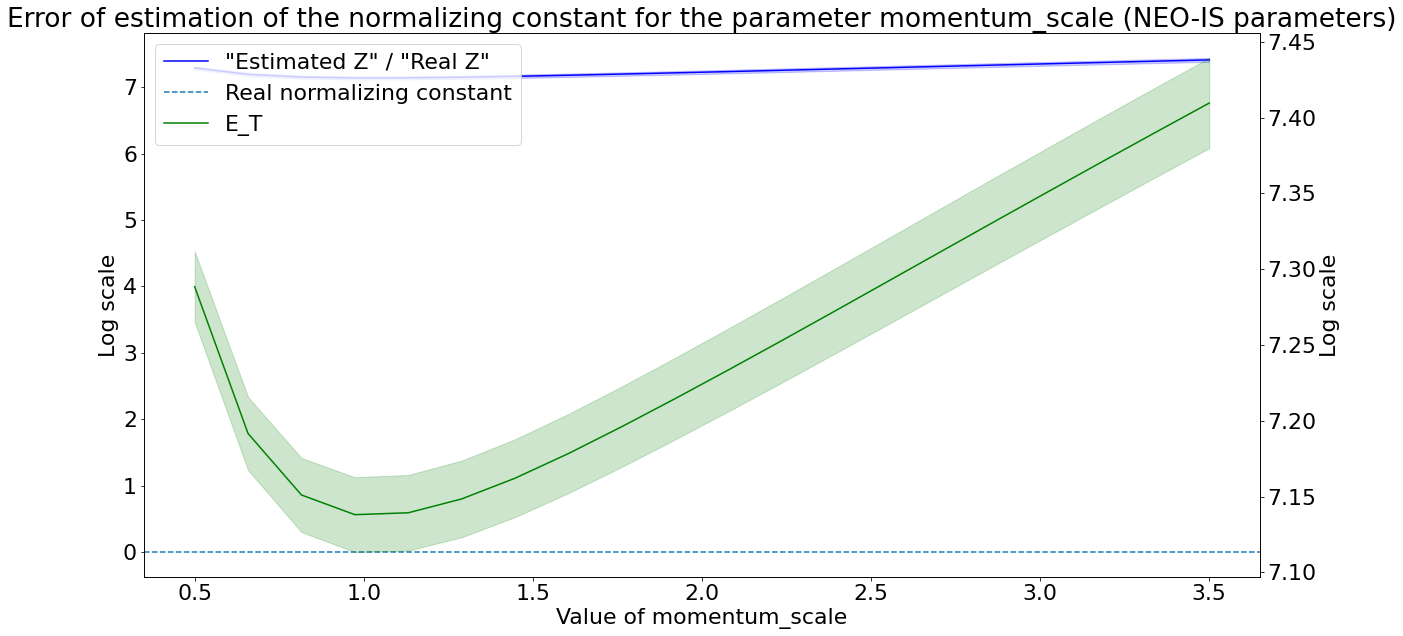

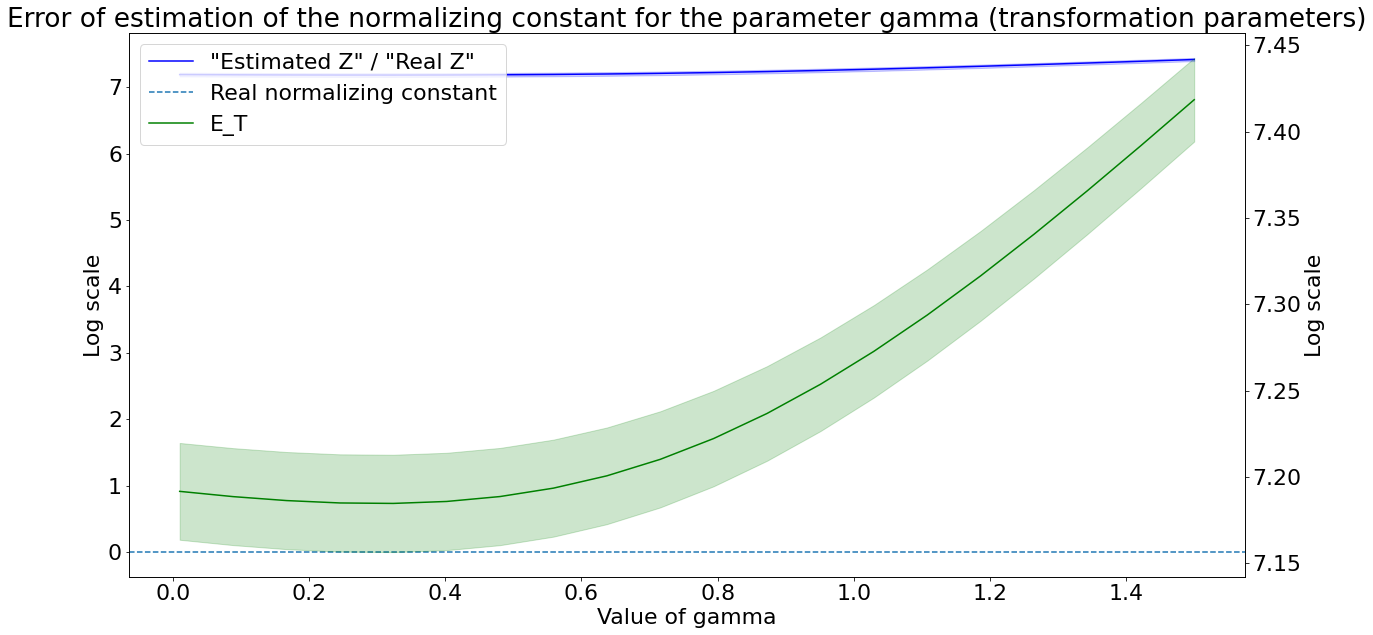

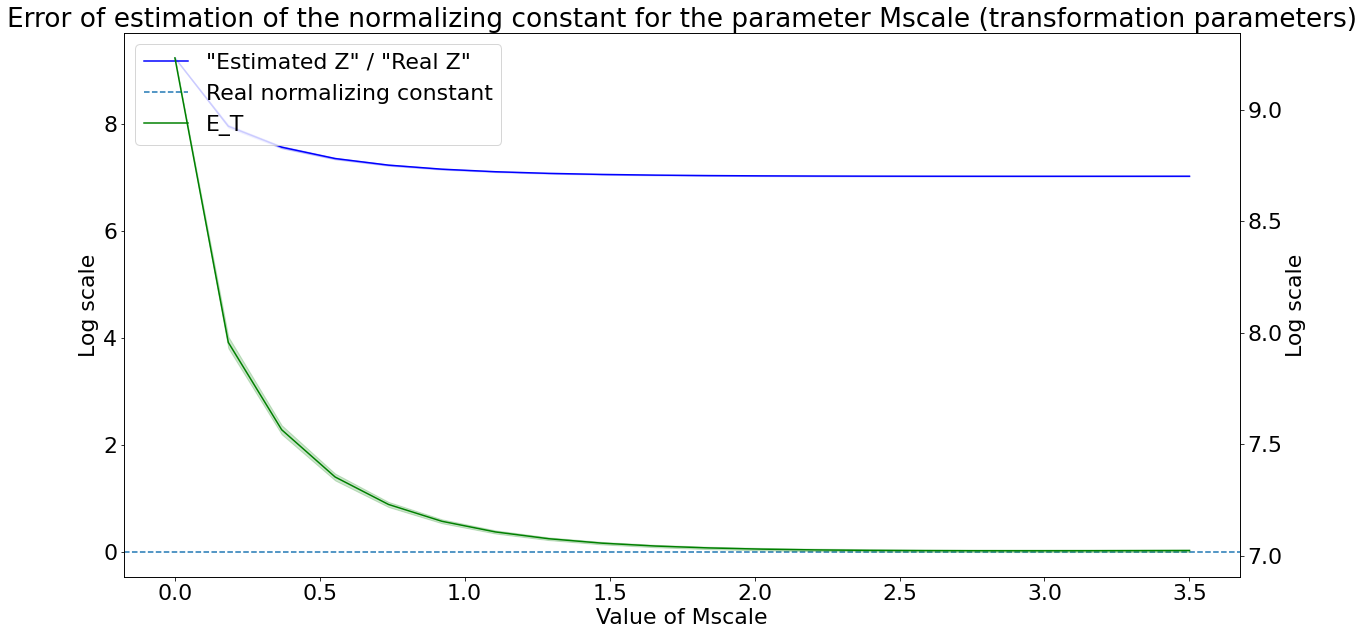

In [ ]:
# Compute the grid search
results_simple_2d = autotune_neo(DampedHamiltonianEuler,
                       transformation_ranges=default_transformation_ranges,
                       neo_ranges=default_neo_ranges,
                       n_samples=simple_2d_is['n_samples'],
                       distributions=simple_2d_distributions,
                       dt=0.1,
                       K=10,
                       dim=2,
                       batch_size=32,
                       key=jax.random.PRNGKey(42))
                       
# Plot parameters
plot_autotune_results(results_simple_2d)

# Get best parameters
best_params_simple_2d = get_best_params(results_simple_2d)

**Interpretation**

These plots shows that the parameters have a big impact on each other (high variance). However, some optimal $\gamma$ and $M$ can be found. See that `momentum_scale` and `Mscale` behave very differently : $M$ is chosen close to the identity for the transformation computation (and has high variance) whereas the artificial scaling for initial sampling goes towards infinity with little variance.

In [ ]:
# Print the optimal parameters
print(best_params_simple_2d)

{'Z': 14.99998, 'E_T': 3028.941, 'neo_params': {'momentum_scale': 3.0263157}, 'transformation_params': {'gamma': 1.0294735, 'Mscale': 0.36931577}}


In [ ]:
# Save of best parameters
best_params_simple_2d = {
  'E_T': 3028.941,
 'Z': 14.99998,
 'neo_params': {
     'momentum_scale': 3.0263157
  },
 'transformation_params': {
     'Mscale': 0.36931577,
     'gamma': 1.0294735
  }
}

In [ ]:
# Transformation and NEO-IS parameters

simple_2d_transformation = {
    'gamma' : best_params_simple_2d['transformation_params']['gamma'],
    'dt' : 0.1,
    'grad_U' : jax.jit(jax.vmap(lambda x : -jax.grad(simple_2d_distributions['target'].log_prob)(x))),
    'Mdim' : 2,
    'Mscale' : best_params_simple_2d['transformation_params']['Mscale']
}

simple_2d_neo = {
    'K' : 10,
    'momentum_scale' : best_params_simple_2d['neo_params']['momentum_scale']
}

In [ ]:
# NEO-IS
simple_2d_neo_ret = []
transformation = DampedHamiltonianEuler(**simple_2d_transformation)
neo_is = NEOIS(**simple_2d_is, **simple_2d_neo, transformation=transformation)
for i in range(n_test):
  simple_2d_neo_ret.append(neo_is.estimate(simple2d_loglikelihood_is, jax.random.PRNGKey((i + 12345) % 8976))[0])

In [ ]:
# Classic IS
simple_2d_classic_is_ret = []
simple_2d_classic_is = dict(simple_2d_is)
simple_2d_classic_is['n_samples'] *= simple_2d_neo['K']
classic_is = ClassicIS(**simple_2d_classic_is)
for i in range(n_test):
  simple_2d_classic_is_ret.append(classic_is.estimate(simple2d_loglikelihood_is, jax.random.PRNGKey((i + 12345) % 8976))[0])

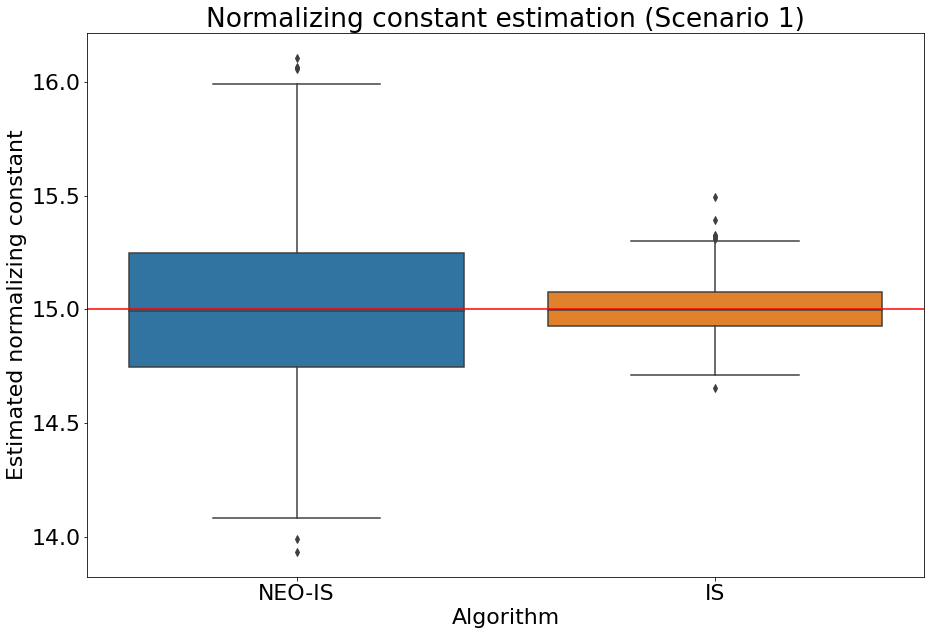

In [ ]:
# Compute the box plot
import seaborn as sns
simple_2d_total_res = [jnp.array(simple_2d_neo_ret), jnp.array(simple_2d_classic_is_ret)]
plt.figure(figsize=(15, 10))
sns.boxplot(data=simple_2d_total_res)
plt.axhline(y=15, color='red')
plt.xticks([0, 1],['NEO-IS','IS'])
plt.ylabel("Estimated normalizing constant")
plt.xlabel("Algorithm")
plt.title("Normalizing constant estimation (Scenario 1)")
plt.show()

**Interpretation**

Those box plots show that both estimators are good on average but NEO-IS has a larger variance. This must be because of the exploration steps of the mapping which can only degrade performance in such a simple (unimodal) setting.

### High-dimensionnal mixture

This scenario was designed to see how the algorithm performs in high dimensions, we have

* $\rho \sim \mathcal{N}(0, I_{15})$
* $m = \rho$
* $\pi \sim \frac{1}{15} \times \text{mixture of 15 gaussians with evenly separated means in } [-1.5, 1.5]^{15}~~ \text{and variances of} ~ 0.8I_{15} $
* $L(x) = \frac{\pi(x)}{\rho(x)}$

In [ ]:
# Build all possibilities of length n from list l
import itertools
def all_positibilities(n, l):
  ret = []
  for subset in itertools.combinations(l, n):
    ret.append(tuple(list(subset) + [0.0]*(len(l)-n)))
  return ret

In [ ]:
# Build the example

simple_mixture_dim = 15

def build_simple_mixture_target(d):
  # Build the means and covs
  means = all_positibilities(d-1, jnp.linspace(-1.5, 1.5, num=d))
  covs = [jnp.sqrt(0.8)] * len(means)
  return tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(probs=[1/len(means)]*len(means)),
    components_distribution=tfp.distributions.MultivariateNormalDiag(loc=means, scale_identity_multiplier=covs))

simple_mixture_distributions = {
    'prior' : tfd.MultivariateNormalDiag(loc=jnp.zeros((simple_mixture_dim,))),
    'importance_distr' : tfd.MultivariateNormalDiag(loc=jnp.zeros((simple_mixture_dim,))),
    'target' : build_simple_mixture_target(simple_mixture_dim)
}

simple_mixture_is = {
    'n_samples' : 10000,
    'prior' : simple_mixture_distributions['prior'],
    'importance_distr' : simple_mixture_distributions['importance_distr'],
}

simple_mixture_loglikelihood_is = jax.jit(lambda x : jnp.log(15) + simple_mixture_distributions['target'].log_prob(x) - simple_mixture_distributions['prior'].log_prob(x))

100%|██████████| 32/32 [02:08<00:00,  4.03s/it]


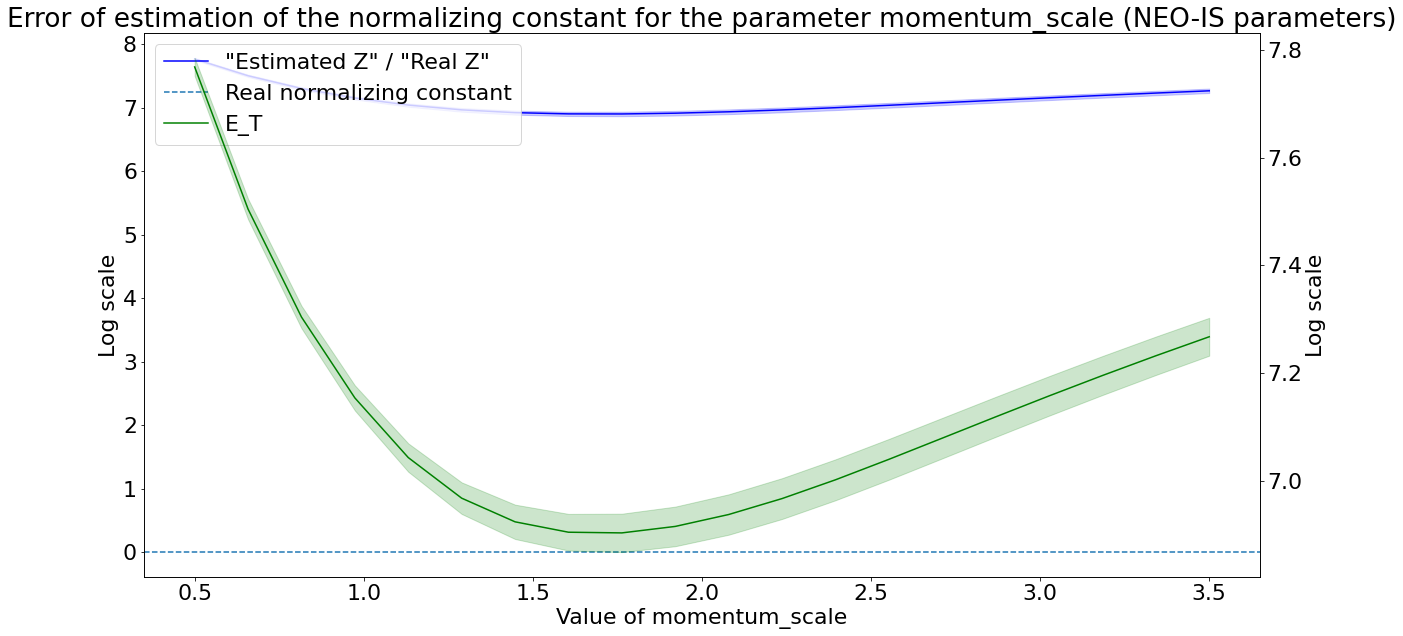

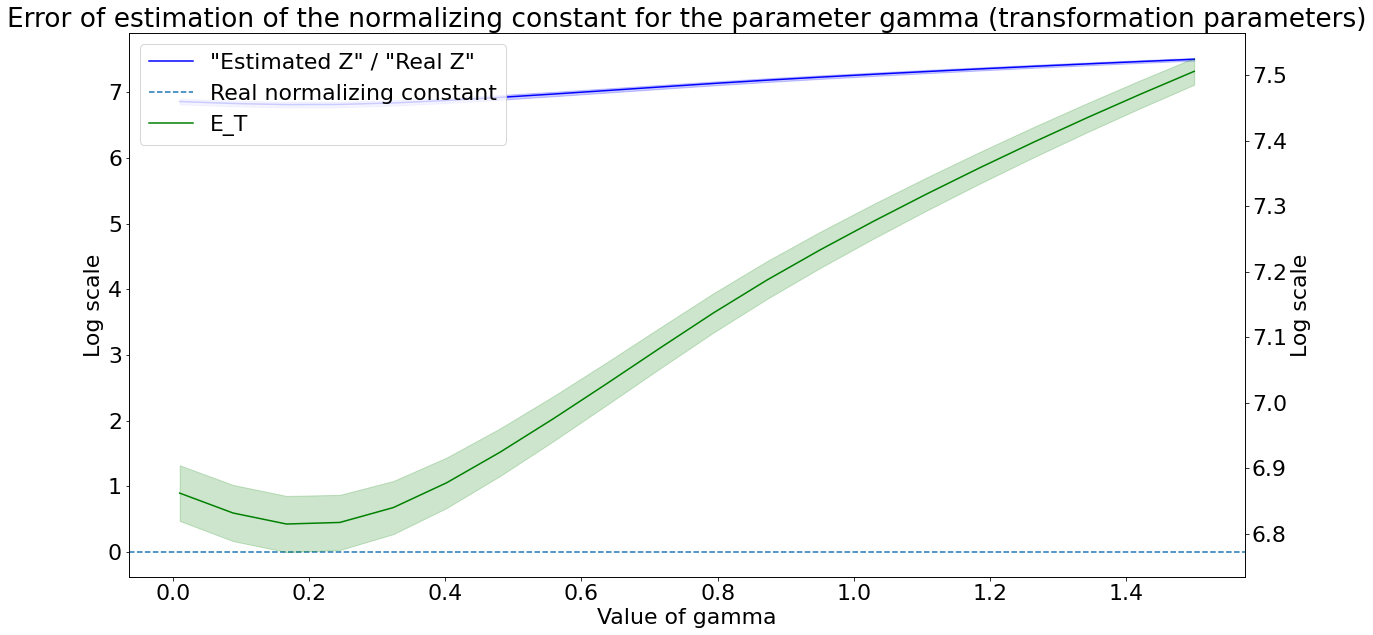

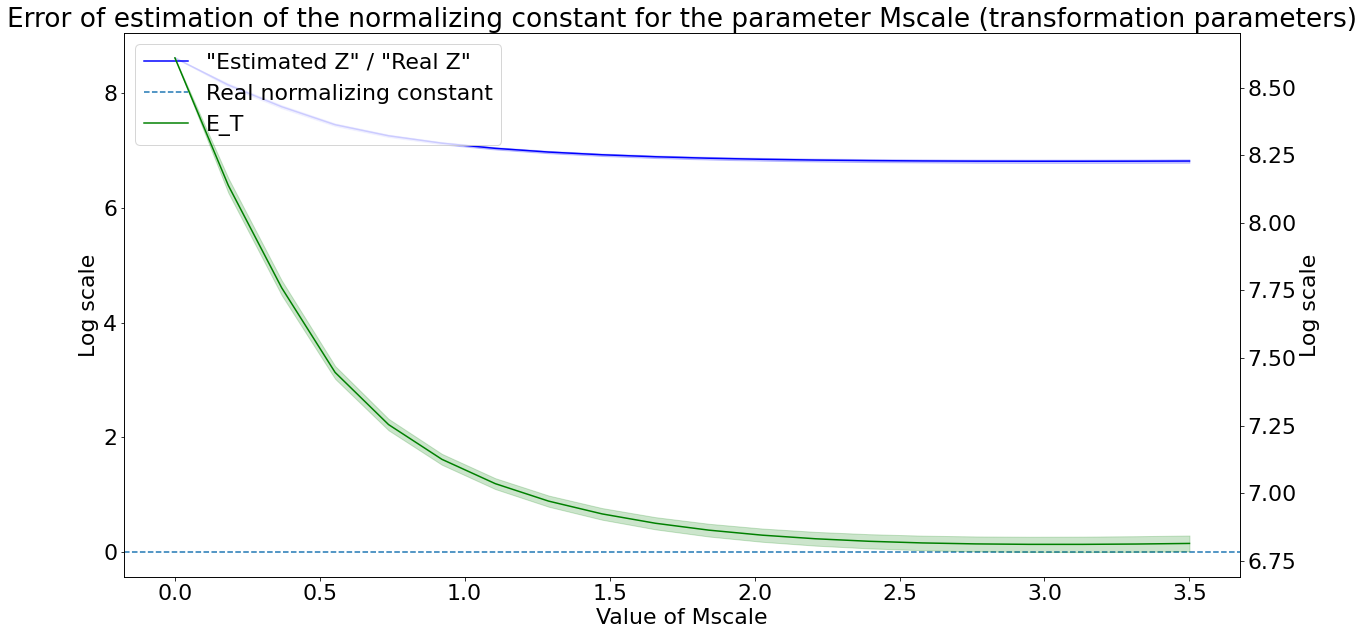

In [ ]:
# Compute the grid search
results_simple_mixture = autotune_neo(DampedHamiltonianEuler,
                       transformation_ranges=default_transformation_ranges,
                       neo_ranges=default_neo_ranges,
                       n_samples=simple_mixture_is['n_samples'],
                       distributions=simple_mixture_distributions,
                       dt=0.1,
                       K=15,
                       dim=simple_mixture_dim,
                       batch_size=32,
                       key=jax.random.PRNGKey(42))
                       
# Plot parameters
plot_autotune_results(results_simple_mixture)

# Get best parameters
best_params_simple_mixture = get_best_params(results_simple_mixture)

**Interpretations**

Parameter tuning gives the same results as before. From our experiments, those plots are typical of gaussian mixtures.

In [ ]:
# Print the optimal parameters
print(best_params_simple_mixture)

{'Z': 14.985838, 'E_T': 3255.9944, 'neo_params': {'momentum_scale': 1.4473684}, 'transformation_params': {'gamma': 0.24526314, 'Mscale': 0.1851579}}


In [ ]:
# Saved best params
best_params_simple_mixture = {'E_T': 3255.9944,
 'Z': 14.985838,
 'neo_params': {'momentum_scale': 1.4473684},
 'transformation_params': {'Mscale': 0.1851579, 'gamma': 0.24526314}}

In [ ]:
# Transformation and NEO-IS parameters

simple_mixture_transformation = {
    'gamma' : best_params_simple_mixture['transformation_params']['gamma'],
    'dt' : 0.1,
    'grad_U' : jax.jit(jax.vmap(lambda x : -jax.grad(simple_mixture_distributions['target'].log_prob)(x))),
    'Mdim' : simple_mixture_dim,
    'Mscale' : best_params_simple_mixture['transformation_params']['Mscale']
}

simple_mixture_neo = {
    'K' : 15,
    'momentum_scale' : best_params_simple_mixture['neo_params']['momentum_scale']
}

In [ ]:
# NEO-IS
simple_mixture_neo_ret = []
transformation = DampedHamiltonianEuler(**simple_mixture_transformation)
neo_is = NEOIS(**simple_mixture_is, **simple_mixture_neo, transformation=transformation)
for i in range(n_test):
  simple_mixture_neo_ret.append(neo_is.estimate(simple_mixture_loglikelihood_is, jax.random.PRNGKey((i + 12345) % 8976))[0])

In [ ]:
# Classic IS
simple_mixture_classic_is_ret = []
simple_mixture_classic_is = dict(simple_mixture_is)
simple_mixture_classic_is['n_samples'] *= simple_mixture_neo['K']
classic_is = ClassicIS(**simple_mixture_classic_is)
for i in range(n_test):
  simple_mixture_classic_is_ret.append(classic_is.estimate(simple_mixture_loglikelihood_is, jax.random.PRNGKey((i + 12345) % 8976))[0])

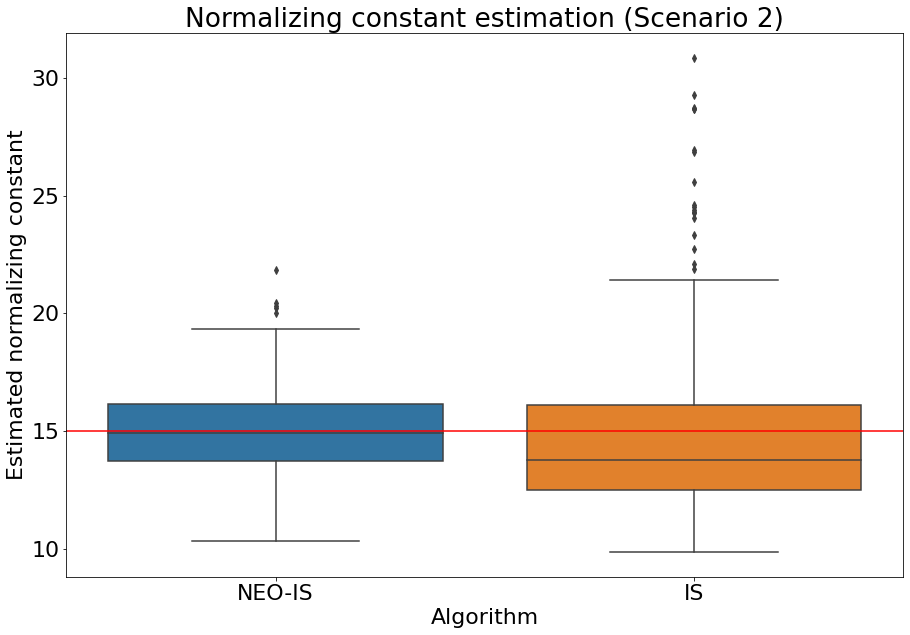

In [ ]:
# Compute the box plot
import seaborn as sns
simple_mixture_total_res = [jnp.array(simple_mixture_neo_ret), jnp.array(simple_mixture_classic_is_ret)]
plt.figure(figsize=(15, 10))
sns.boxplot(data=simple_mixture_total_res)
plt.axhline(y=15, color='red')
plt.xticks([0, 1],['NEO-IS','IS'])
plt.ylabel("Estimated normalizing constant")
plt.xlabel("Algorithm")
plt.title("Normalizing constant estimation (Scenario 2)")
plt.show()

**Interpretation**

Here, NEO-IS shows its superiority : not only it is better in average but its variance is also much small despite the high-dimensional setting.

### Highly multi-modal 2D Gaussian

In this scenario design to see how the algorithm performs with a large number of well-separated modes, we have

* $\rho \sim \mathcal{N}(0, I_{2})$
* $m = \rho$
* $\displaystyle \pi \sim \frac{1}{15} \times \frac{1}{7\times 7} \sum_{i = -7}^7 \sum_{j = -7}^7 \mathcal{N}(\begin{pmatrix} i \\ j \end{pmatrix}, \sqrt{0.6 (1 - \frac{ij}{50})} I_2)$
* $L(x) = \frac{\pi(x)}{\rho(x)}$

In [ ]:
def build_multi_modal_target(n_modes):
  # Build the means and covs
  ret_means = []
  ret_covs = []
  c = 0
  for i in jnp.linspace(-7, 7, num=n_modes//2):
    for j in jnp.linspace(-7, 7, num=n_modes//2):
      ret_means.append(jnp.array([i,j]))
      ret_covs.append(jnp.sqrt(0.6 * (1 - (i*j) / 50)))
      c += 1
  return tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(probs=[1/c]*c),
    components_distribution=tfp.distributions.MultivariateNormalDiag(loc=ret_means, scale_identity_multiplier=ret_covs))

In [ ]:
# Build the example

multi_modal_n_modes = 20

multi_modal_distributions = {
    'prior' : tfd.MultivariateNormalDiag(loc=jnp.zeros((2,))),
    'importance_distr' : tfd.MultivariateNormalDiag(loc=jnp.zeros((2,))),
    'target' : build_multi_modal_target(multi_modal_n_modes)
}

multi_modal_is = {
    'n_samples' : 10000,
    'prior' : multi_modal_distributions['prior'],
    'importance_distr' : multi_modal_distributions['importance_distr'],
}

multi_modal_loglikelihood_is = jax.jit(lambda x : jnp.log(15) + multi_modal_distributions['target'].log_prob(x) - multi_modal_distributions['prior'].log_prob(x))

100%|██████████| 32/32 [07:25<00:00, 13.91s/it]


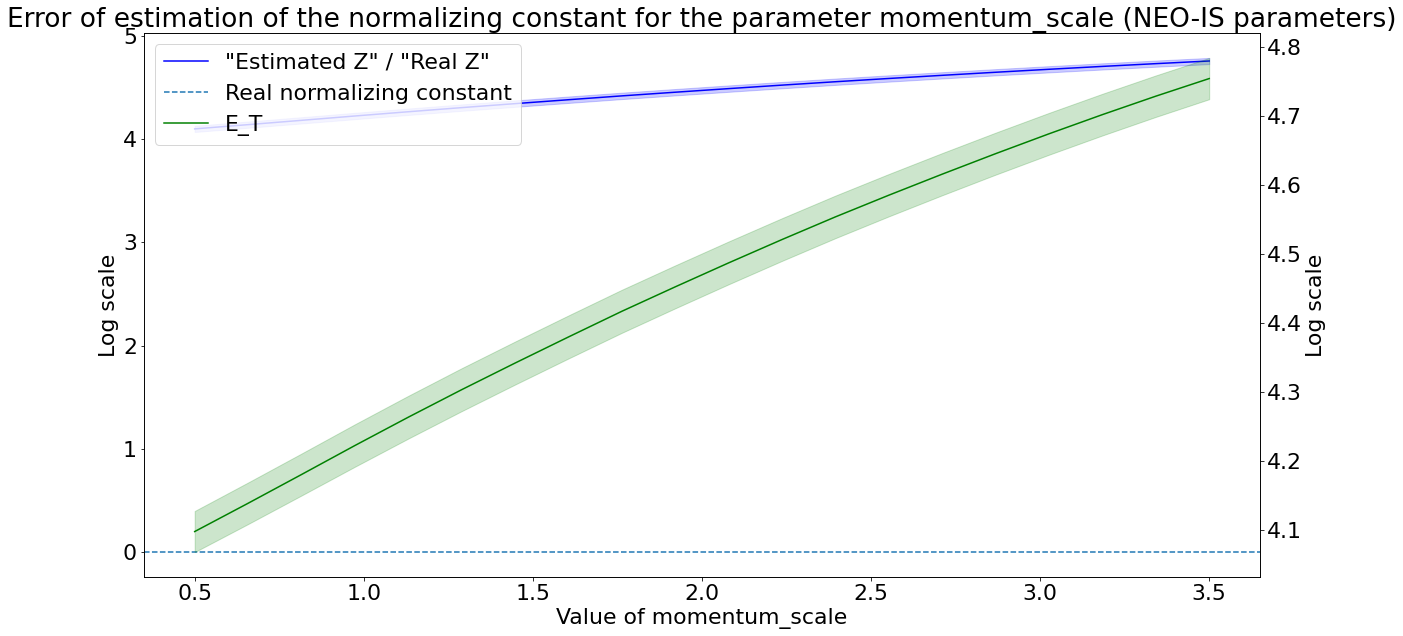

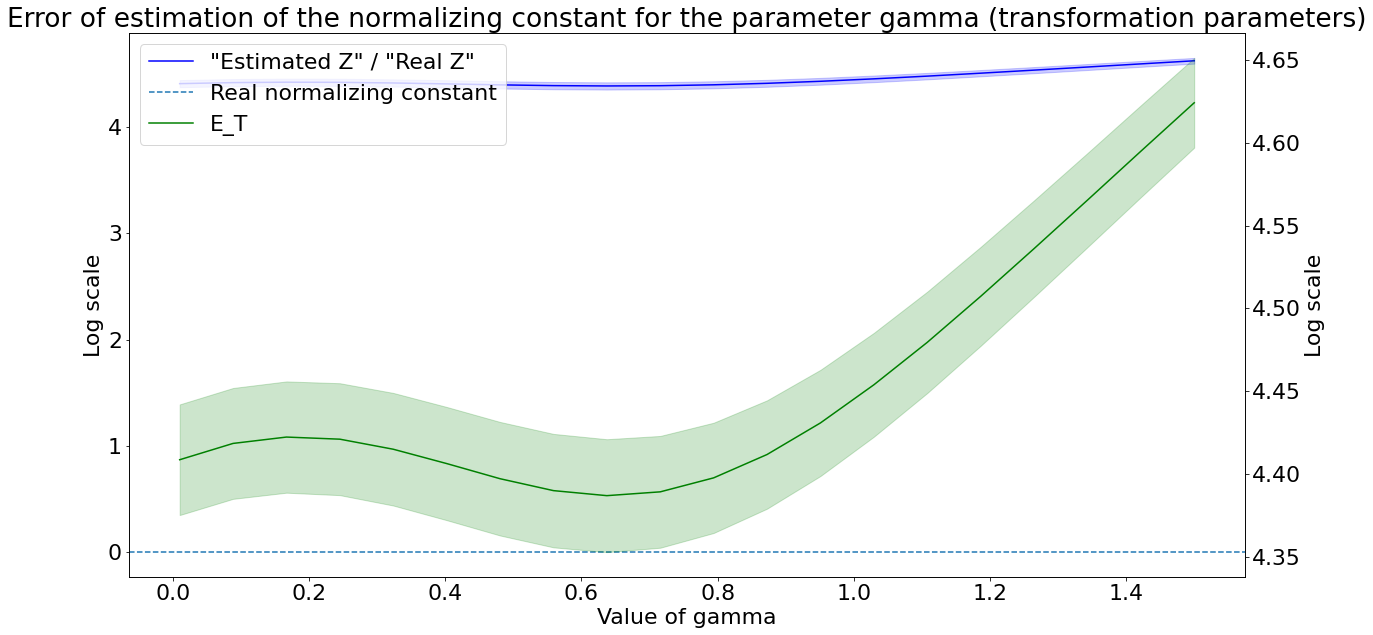

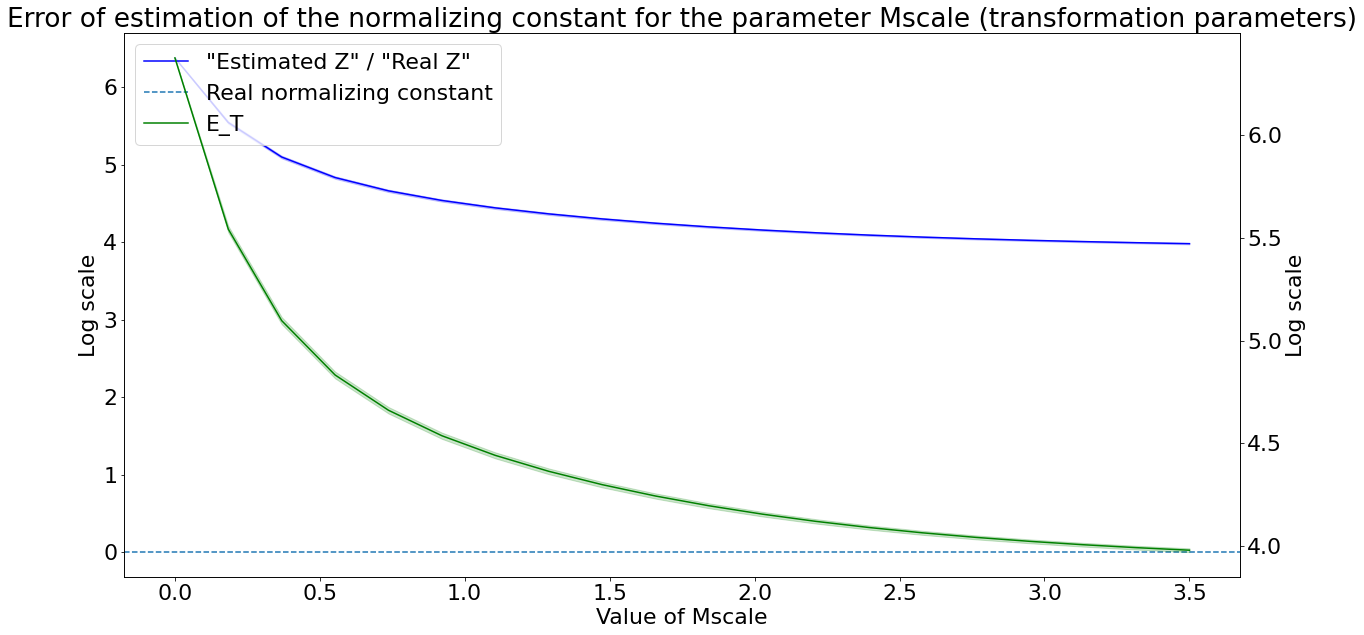

In [ ]:
# Compute the grid search
results_multi_modal = autotune_neo(DampedHamiltonianEuler,
                       transformation_ranges=default_transformation_ranges,
                       neo_ranges=default_neo_ranges,
                       n_samples=multi_modal_is['n_samples'],
                       distributions=multi_modal_distributions,
                       dt=0.1,
                       K=15,
                       dim=2,
                       batch_size=32,
                       key=jax.random.PRNGKey(42))
                       
# Plot parameters
plot_autotune_results(results_multi_modal)

# Get best parameters
best_params_multi_modal = get_best_params(results_multi_modal)

**Interpretation**

Here we are right of the edge of parameter tuning. Indeed, as the number of models increases (ie. the density gets flatter) tuning hyperparamters becomes very hard (especially for tuning $M$). We tried the second order mapping but only found even more unstable results.

In [ ]:
# Print the optimal parameters
print(best_params_multi_modal)

{'Z': 7.278316, 'E_T': 284.5295, 'neo_params': {'momentum_scale': 2.0789473}, 'transformation_params': {'gamma': 0.24526314, 'Mscale': 0.1851579}}


In [ ]:
# Save the best parameters
best_params_multi_modal = {'E_T': 284.5295,
 'Z': 7.278316,
 'neo_params': {'momentum_scale': 2.0789473},
 'transformation_params': {'Mscale': 0.1851579, 'gamma': 0.24526314}}

In [ ]:
# Transformation and NEO-IS parameters

multi_modal_transformation = {
    'gamma' : best_params_multi_modal['transformation_params']['gamma'],
    'dt' : 0.1,
    'grad_U' : jax.jit(jax.vmap(lambda x : -jax.grad(multi_modal_distributions['target'].log_prob)(x))),
    'Mdim' : 2,
    'Mscale' : best_params_multi_modal['transformation_params']['Mscale']
}

multi_modal_neo = {
    'K' : 15,
    'momentum_scale' : best_params_multi_modal['neo_params']['momentum_scale']
}

In [ ]:
# Classic IS
multi_modal_classic_is_ret = []
multi_modal_classic_is = dict(multi_modal_is)
multi_modal_classic_is['n_samples'] *= multi_modal_neo['K']
classic_is = ClassicIS(**multi_modal_classic_is)
for i in range(n_test):
  multi_modal_classic_is_ret.append(classic_is.estimate(multi_modal_loglikelihood_is, jax.random.PRNGKey((i + 12345) % 8976))[0])

In [ ]:
# NEO-IS
multi_modal_neo_ret = []
transformation = DampedHamiltonianEuler(**multi_modal_transformation)
neo_is = NEOIS(**multi_modal_is, **multi_modal_neo, transformation=transformation)
for i in range(n_test):
  multi_modal_neo_ret.append(neo_is.estimate(multi_modal_loglikelihood_is, jax.random.PRNGKey((i + 12345) % 8976))[0])

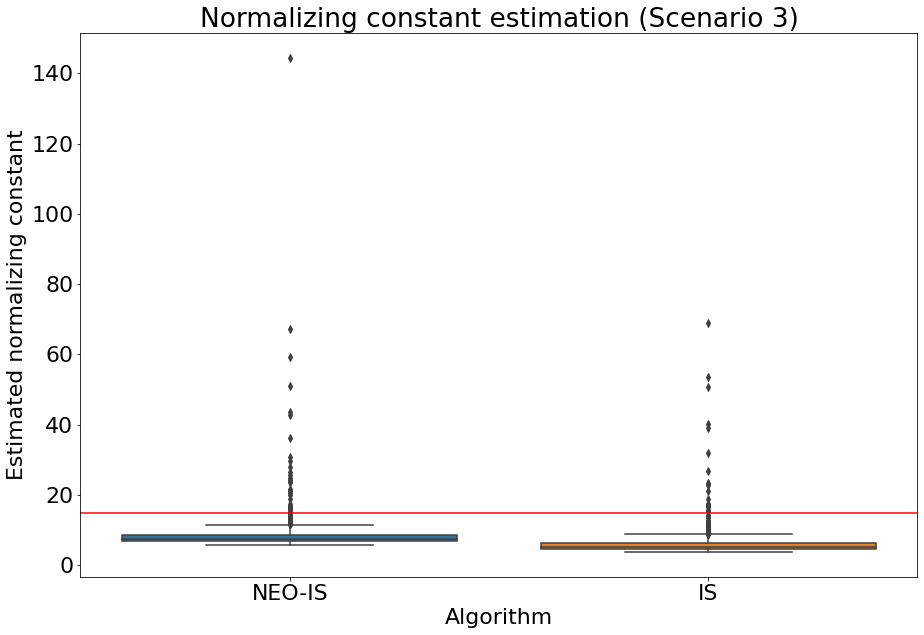

In [ ]:
# Compute the box plot
import seaborn as sns
multi_modal_total_res = [jnp.array(multi_modal_neo_ret), jnp.array(multi_modal_classic_is_ret)]
plt.figure(figsize=(15, 10))
sns.boxplot(data=multi_modal_total_res)
plt.axhline(y=15, color='red')
plt.xticks([0, 1],['NEO-IS','IS'])
plt.ylabel("Estimated normalizing constant")
plt.xlabel("Algorithm")
plt.title("Normalizing constant estimation (Scenario 3)")
plt.show()

**Interpretation**

Clearly, NEO-IS is closer to the result compared to normal IS. However, it is still far away and its variance doesn't even touch the expected result. A better mapping (and maybe a more complex $\overline{\omega}_k$) might solve this problem.

# Iterated Sampling Importance Resampling

**Sampling Importance Resampling**

The Sampling-Importance Resampling (SIR) algorithm introduced by [Rubin and B, 1987], aims at drawing a sample from a target distribution $\pi$. The intuition behind this algorithm can be formulated as following: 

* We want samples from a distribution $\pi$
* We have a proposed distribution $\rho$ (a distribution which is easy for us to sample from, and which should be a good approximation to $\pi$)


This can be done with the following algorithm

1. **(Sampling)** We first sample from the distribution $\rho$, and we obtain:

    $$(Y_k)_{1 \leq k \leq n}$$

    where $Y_k \sim \rho$

2.  **(Importance)** We can write $\pi(x) $ as $\pi(x) = \frac{\pi(x)}{\rho(x)} \cdot \rho(x) $
    
    We then consider the ratios as weights:
    $$W_k = \frac{\pi(Y_k)}{\rho(Y_k)} \ \ \ \ \ Y_k \sim \rho $$ 
    and normalize those weights : 
    $$ W_k = \frac{W_k}{\sum_{i = 1}^{n}W_i} $$

3. **(Resampling)** We take the drawn samples and resample from them according to those probabilities(the normalized weights). So, we get :

    $$X_k = Y_i ~ \text{with probability} ~ W_i'$$

Just like basic sampling, the algorithm can be used *with* or *without replacement.*

The SIR algorithm was later improved in [SKare et al., 2003], by adjusting the normalized weights.

We supposed the target density $\pi$ is of form $\pi(x) \propto \rho(x)L(x)$ where $\rho$ is a probability density function and L(x) a computable non-negative function. 

We saw that in [Rubin and B, 1987], the weights $ W(X_k) \propto L(X_k) $ 

The new weights introduced in [SKare et al., 2003] are : 

$$W(X_k) \propto \frac{L(X_k)}{S_{-k}} \,  \,  \, where \, \,  \, S_{-k} = \sum_{j = 1}^{n} L(X_j) - L(X_k)\,  \,  \,  \, (1)$$ 

for the *Improved SIR with replacement*, and : 

$$W(X_k) \propto \frac{L(X_k)}{S_{(m) - mL(X_k)}} \,  \,  \, where \, \,  \, S_{(m)} = \sum_{i = 1}^{n} L(X_i) -\sum_{i = 1}^{m - 1} L(X_i) \, \, m > 1$$ 

for the $m^{th}$ draw of the *Improved SIR without replacement*, the first draw being given by (1). 

These adjusted probabilities help reducing the bias of the Importance Sampling estimate. It has been shown that the SIR algorithm without replacement converges faster than the one with replacement. 

**Implementation**

The class `iSIR` is implementing Iterated Importance Resampling by building a new object from any instance of `ClassicIS`. The latter implements `log_estimate_gibbs_correlated` which will perform the first and second step (**Sampling** and **Importance**) then `iSIR` implements the **Resampling** step in `sample_step` which is **iterated** in `chain_sample`. The `chain_sample` function takes the length of the chain $n$, the number of chains to compute in parallel $n_c$ as well as the likelihood $L(x)$ to compute the importance weights.

In [ ]:
class iSIR:

  def __init__(self, is_estimator):
    self.estimator = is_estimator
    self.use_extended_prior = is_estimator.use_extended_prior
  
  @partial(jax.jit, static_argnums=(0,4))
  def sample_step(self, traj, weights, idx, loglikelihood, seed):
    # Unpack idx
    if self.use_extended_prior:
      i, k = idx
    else:
      i = idx
    # Extract the i-th trajectory and select the first chain
    if self.use_extended_prior:
      traj_cur = (traj[0][:,i,0], traj[1][:,i,0])
      weights_cur = weights[:,i,0]
    else:
      traj_cur = traj[i,0]
      weights_cur = weights[i,0]
    # Compute the weights
    weights_new, traj_new, seed_next = self.estimator.log_estimate_gibbs_correlated(traj_cur, loglikelihood, seed)
    # Concatenate everything
    if self.use_extended_prior:
      weights_tot = jnp.hstack([jnp.expand_dims(weights_cur, axis=1), weights_new])
      traj_tot_q = jnp.hstack([jnp.expand_dims(traj_cur[0], axis=1), traj_new[0]])
      traj_tot_p = jnp.hstack([jnp.expand_dims(traj_cur[1], axis=1), traj_new[1]])
      traj_tot = (traj_tot_q, traj_tot_p)
    else:
      weights_tot = jnp.vstack([jnp.expand_dims(weights_cur, axis=0), weights_new])
      traj_tot = jnp.vstack([jnp.expand_dims(traj_cur, axis=0), traj_new])
    # Compute the indexes
    if self.use_extended_prior:
      est_traj = jsc.special.logsumexp(weights_tot, axis=0)
    else:
      est_traj = weights_tot
    i_new = jax.random.categorical(key=seed_next, logits=est_traj.T)
    # Update the key
    _, seed_next = jax.random.split(seed_next)
    # Select the trajectory
    if self.use_extended_prior:
      traj_cur_new = (traj_tot[0][:,i_new,0], traj_tot[1][:,i_new,0])
      weights_cur_new = weights_tot[:,i_new,0]
    else:
      traj_cur_new = traj_tot[i_new,0]
      weights_cur_new = weights_tot[i_new,0]
    # Return the trajectory
    if self.use_extended_prior:
      # Sample from K
      k_new = jax.random.categorical(key=seed_next, logits=weights_cur_new.T)
      # Update the key
      _, seed_next = jax.random.split(seed_next)
      # Return
      return traj_tot, weights_tot, (i_new, k_new), (traj_cur_new[0][k_new][:,0], traj_cur_new[1][k_new][:,0]), seed_next
    else:
      return traj_tot, weights_tot, i_new, traj_cur_new, seed_next
    
  def chain_sample(self, n, n_chain, loglikelihood, seed):
    # Initial trajectory
    if self.use_extended_prior:
      seed_q, seed_p, seed_next = jax.random.split(seed, num=3)
      q = self.estimator.importance_distr.sample((self.estimator.K, self.estimator.n_samples, n_chain, ), seed=seed_q)
      p = self.estimator.momentum_dist.sample(q.shape[:-1], seed=seed_p)
      init_traj = (q,p)
    else:
      seed_q, seed_next = jax.random.split(seed)
      init_traj = self.estimator.importance_distr.sample((self.estimator.n_samples, n_chain, ), seed=seed_q)
    # Initial indexes set at 0
    i = jnp.zeros(n_chain, dtype=int)
    if self.use_extended_prior:
      k = jnp.zeros(n_chain, dtype=int)
      init_idx = (i,k)
    else:
      init_idx = i
    # Initialize weights
    if self.use_extended_prior:
      init_weights = jnp.log(jnp.zeros((self.estimator.K, self.estimator.n_samples, n_chain)))
    else:
      init_weights = jnp.log(jnp.zeros((self.estimator.n_samples, n_chain)))
    # Recurrent call
    def sampling_step_rec(carry, x):
      # Unpack the carry
      traj, weights, idx, cur_seed = carry
      # Sample
      traj_new, weights_new, idx_new, y, seed_next = self.sample_step(traj, weights, idx, loglikelihood, cur_seed)
      return (traj_new, weights_new, idx_new, seed_next), y
    _, samples = jax.lax.scan(sampling_step_rec, (init_traj, init_weights, init_idx, seed_next), jnp.arange(n))
    # Return proudly made samples
    return samples

In [ ]:
# Sampling constants
sampling_parameters = {
    'n' : 40000,
    'n_samples' : 10,
    'n_chain' : 1
}

**NEO-MCMC**
<br>
After getting an idea of the Sampling-Importance Resampling mechanism, we can now deep into the NEO-MCMC sampler proposed in the paper. As stated before, NEO-MCMC is a combination of the NEO framework with the SIR mechanism. We recall that in order to estimate the target $\pi(f)=\int{\pi(x)f(x) \,dx}$, we use the NEO-SNIS estimator $J^{NEO}_{\bar{w}, N}(f)$ built upon the unbiased NEO-IS estimate. The SIR mechanism is then used to sample the NEO-SNIS estimator.
A high level idea is that, in order to sample $ J^{NEO}_{\bar{w}, N}(f)$, 
<br>
$\ \ \ \ \ \ \ \ $  1.  We sample from $ \rho $, and compute both the forward and backward orbits associated to those samples;
<br>
$\ \ \ \ \ \ \ \ $ 2. Similarly to SIR, we then sample an orbit index with probabilities the normalized weights, and draw an iteration index of the orbit index  with probabilities the normalized weights associated to the previously sample index. 


The NEO-MCMC algorithm is an iteraton of the procedure described above, which $ n^{th} $ step can be formulated as following : 
<br>
At step $n \in \mathbf{N}^{\star}$, given the conditioning orbit point  $Y_{n-1} $

$ \ \ \ \ \ \ \ \ \ $ 1. **We first update the conditioning point**
<br>
$ \ \ \ \ \ \ \ \ \  \  \ $ $\star$ Set $X^1_n = Y_{n - 1}$  and for any $i \in \{2, \ldots N\}$, sample $ X^i_n \sim \rho$ with  $(X_n^i) i.i.d $ (we make sure to keep a conditioning point)
<br>
$ \ \ \ \ \ \ \ \ \  \  \ $  $\star$Sample the orbit $ I_n $ with probability proportional to $ (\hat{Z}_{X^{1:N}}^{\bar{w}})_{1 \leq i \leq N}$
<br>
$ \ \ \ \ \ \ \ \ \  \  \ $  $\star$Set $Y_n = X_n^{I_n}$
<br>

$ \ \ \ \ \ \ \ \ \ $ 2. **We output a sample**
<br>
$ \ \ \ \ \ \ \ \ \  \  \ $  $\star$Sample index $ K_n $ with probability proportional to $\{w_k(Y_n)L(T^k(Y_n))/\hat{Z}_{Y_n}^{\bar{w}}\}_{k \in \mathbf{Z}}$
<br>
        $ \ \ \ \ \ \ \ \ \  \  \ $  $\star$Output $ U_n = T^{K_{n}}(Y_n) $

We note that $ (Y_n) $ is a markov chain with associated markov kernel P where

$$\displaystyle P(y, A) = \int{\delta_{y}(dx^1)\prod_{j = 2}^{N} \rho(x^j)dx^j\sum_{i = 1}^{N} \frac{\hat{Z}_{x^i}}{\sum_{j = 1}^{N} \hat{Z}_{x^j}} \mathbf{1}_{A}(x^i)} ~~~~~~~~  y \in \mathbf{R}^d, A \in \mathcal{B}(\mathbf{R}^d)$$
As we will see in numerical illustrations, NEO-MCMC outperforms the well-known MCMC algorithms such as Metropolis-Hastings, or Hamiltonian Monte-Carlo.

***Theoritical guarantees of NEO-MCMC***

In [Thin et al., 2021], a few key theorems are securing the good properties of the algorithm.

First, the Markov kernel induced by NEO-MCMC is $\tilde{\pi}$-reversible and ergodic. The reversibility implies that the kernel is $\tilde{\pi}$ invariant and the ergodicity ensures the validity of the law of large numbers. It is also Harris positive (which means that for all $y \in \mathbf{R}^d$, $\lim_{n \rightarrow \infty} {\vert \vert{P^n(y,.) - \tilde{\pi}}\vert \vert}_{TV} = 0$ where $P$ is the kernel of the $Y_n$) which ensures a much stronger convergence than a convergence in distribution.

Moreover, assuming that $M_T^{\overline{\omega}} < \infty$, if we set $\epsilon_N = \frac{N-1}{2M_T^{\overline{\omega}} + N - 2}$ and $\kappa_N = 1 - \epsilon_N$, then for any $y \in \mathbf{R}^d$ and $k \in \mathbf{N}$, we have ${\vert \vert{P^k(y,.) - \tilde{\pi}}\vert \vert}_{TV} \leq \kappa_N^k$ and ${\vert \vert P^kQ(y,.) - \pi \vert \vert}_{TV} \leq \kappa_N^k$ (where $Q$ is the kernel of the $U_n$) which ensures the central limit theorem.

**Implementation details of NEO-MCMC**

The main drawback of the current code is that the "dimension" of the extended prior/posterior is hardcoded : for classic IS it's $(z)$ and and for NEO-MCMC it's $(p,q)$. This makes the code pretty heavy (but slightly easier to read and debug). A unification wouldn't be hard and we'll be done later.

Moreover, the update of the conditionning point is a bit tricky. Indeed, the original paper suggests to set $X_n^1 = Y_{n-1}$ and to draw the rest of the particles independantly. However, it's hidden that the samples $X_n^2, \ldots, X_n^N$ are actually drawn **conditionally** to $X_n^1$ (otherwise the exploration capabilities would be pretty bad). Following the code of Achille Thin, we decided to implement a simple Random Walk Metropolis Hasting to do this task of sampling a chain starting from $X_n^1$.

## Experiments

To evaluate the properties of NEO-MCMC, we developed a benchmark comparing NEO-MCMC against the algorithms saw during the course : classic i-SIR, Random Walk Metropolis Hasting, MALA and HMC. This is automatically done by `benchmark_samplers` and vizualized by `plot_samples`. We decided not to investigate too much the computational aspects of NEO-MCMC despite it being very efficient on a parallel architecture.

In [ ]:
# Perform a benchmark
def benchmark_samplers(is_params, neo_params, transformation_params, distributions, sampling_params, loglikelihood, seed):

  # Modify IS params
  is_params['n_samples'] = sampling_parameters['n_samples']

  # Classic i-SIR
  classic_is = ClassicIS(**is_params)
  classic_sampler = iSIR(classic_is)
  q_classic_is = classic_sampler.chain_sample(sampling_parameters['n'], sampling_parameters['n_chain'], loglikelihood=loglikelihood, seed=seed)
  q_classic_is = q_classic_is.reshape((q_classic_is.shape[0] * q_classic_is.shape[1], q_classic_is.shape[2]))

  # NEO-MCMC
  transformation = DampedHamiltonianEuler(**transformation_params)
  neo_is = NEOIS(**is_params, **neo_params, transformation=transformation)
  neo_sampler = iSIR(neo_is)
  q_neo_is, _ = neo_sampler.chain_sample(sampling_parameters['n'], sampling_parameters['n_chain'], loglikelihood=loglikelihood, seed=seed)
  q_neo_is = q_neo_is.reshape((q_neo_is.shape[0] * q_neo_is.shape[1], q_neo_is.shape[2]))

  # RW-MH MCMC
  q_mh = tfp.mcmc.sample_chain(
      num_results=sampling_params['n'],
      current_state=jnp.zeros((sampling_params['n_chain'], 2)),
      kernel=tfp.mcmc.RandomWalkMetropolis(
          target_log_prob_fn=distributions['target'].log_prob,
          new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1)),
      seed=seed,
      trace_fn=None)
  q_mh = q_mh.reshape((q_mh.shape[0] * q_mh.shape[1], q_mh.shape[2]))

  # MALA
  q_mala = tfp.mcmc.sample_chain(
      num_results=sampling_params['n'],
      current_state=jnp.zeros((sampling_params['n_chain'], 2)),
      kernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
          target_log_prob_fn=distributions['target'].log_prob,
          step_size=0.1),
      seed=seed,
      trace_fn=None)
  q_mala = q_mala.reshape((q_mala.shape[0] * q_mala.shape[1], q_mala.shape[2]))

  # HMC
  q_hmc = tfp.mcmc.sample_chain(
      num_results=sampling_params['n'],
      current_state=jnp.zeros((sampling_params['n_chain'], 2)),
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=distributions['target'].log_prob,
          step_size=0.1,
          num_leapfrog_steps=2),
      seed=seed,
      trace_fn=None)
  q_hmc = q_hmc.reshape((q_hmc.shape[0] * q_hmc.shape[1], q_hmc.shape[2]))

  # Return everything
  return q_classic_is, q_neo_is, q_mh, q_mala, q_hmc

In [ ]:
# Plot everything
def plot_samples(target, q_classic_is, q_neo_is, q_mh, q_mala, q_hmc, grid_lim, nb_points=1000, alpha_plots=0.7, alpha_td=1.0, scenario_num=1):
  # Colors
  colors = ['pink','red','green','orange','purple']
  # Evaluate the target density
  grid_plot = (-grid_lim, grid_lim, -grid_lim, grid_lim)
  xplot = jnp.linspace(-grid_lim, grid_lim, nb_points)
  yplot = jnp.linspace(-grid_lim, grid_lim, nb_points)
  Xplot, Yplot = jnp.meshgrid(xplot, yplot)
  td = target.prob(jnp.dstack([Xplot, Yplot]))
  # Figure size
  plt.figure(figsize=(30,20), facecolor='white')
  # Plot the target density
  plt.subplot(2, 3, 1)
  plt.imshow(td, alpha=alpha_td, extent=grid_plot, cmap='Blues', origin='top')
  plt.title("Target density (Scenario {})".format(scenario_num))
  # Classic i-SIR
  plt.subplot(2, 3, 2)
  plt.imshow(td, alpha=alpha_td, extent=grid_plot, cmap='Blues', origin='top')
  plt.scatter(q_classic_is[:,0], q_classic_is[:,1], label="Classic i-SIR", color=colors[0], alpha=alpha_plots)
  plt.title("Classic i-SIR")
  # NEO-MCMC
  plt.subplot(2, 3, 3)
  plt.imshow(td, alpha=alpha_td, extent=grid_plot, cmap='Blues', origin='top')
  plt.scatter(q_neo_is[:,0], q_neo_is[:,1], label="NEO-MCMC", color=colors[1], alpha=alpha_plots)
  plt.title("NEO-MCMC")
  # Random Walk Metropolis Hastings
  plt.subplot(2, 3, 4)
  plt.imshow(td, alpha=alpha_td, extent=grid_plot, cmap='Blues', origin='top')
  plt.scatter(q_mh[:,0], q_mh[:,1], label="RW-MH", color=colors[2], alpha=alpha_plots)
  plt.title("Random Walk Metropolis Hastings")
  # Metropolis-Adjusted Langevin Algorithm
  plt.subplot(2, 3, 5)
  plt.imshow(td, alpha=alpha_td, extent=grid_plot, cmap='Blues', origin='top')
  plt.scatter(q_mala[:,0], q_mala[:,1], label="MALA", color=colors[3], alpha=alpha_plots)
  plt.title("Metropolis-Adjusted Langevin Algorithm")
  # Hamiltonian Monte Carlo
  plt.subplot(2, 3, 6)
  plt.imshow(td, alpha=alpha_td, extent=grid_plot, cmap='Blues', origin='top')
  plt.scatter(q_hmc[:,0], q_hmc[:,1], label="HMC", color=colors[4], alpha=alpha_plots)
  plt.title("Hamiltonian Monte Carlo")
  # Show
  plt.show()

### Simple 2D Gaussian

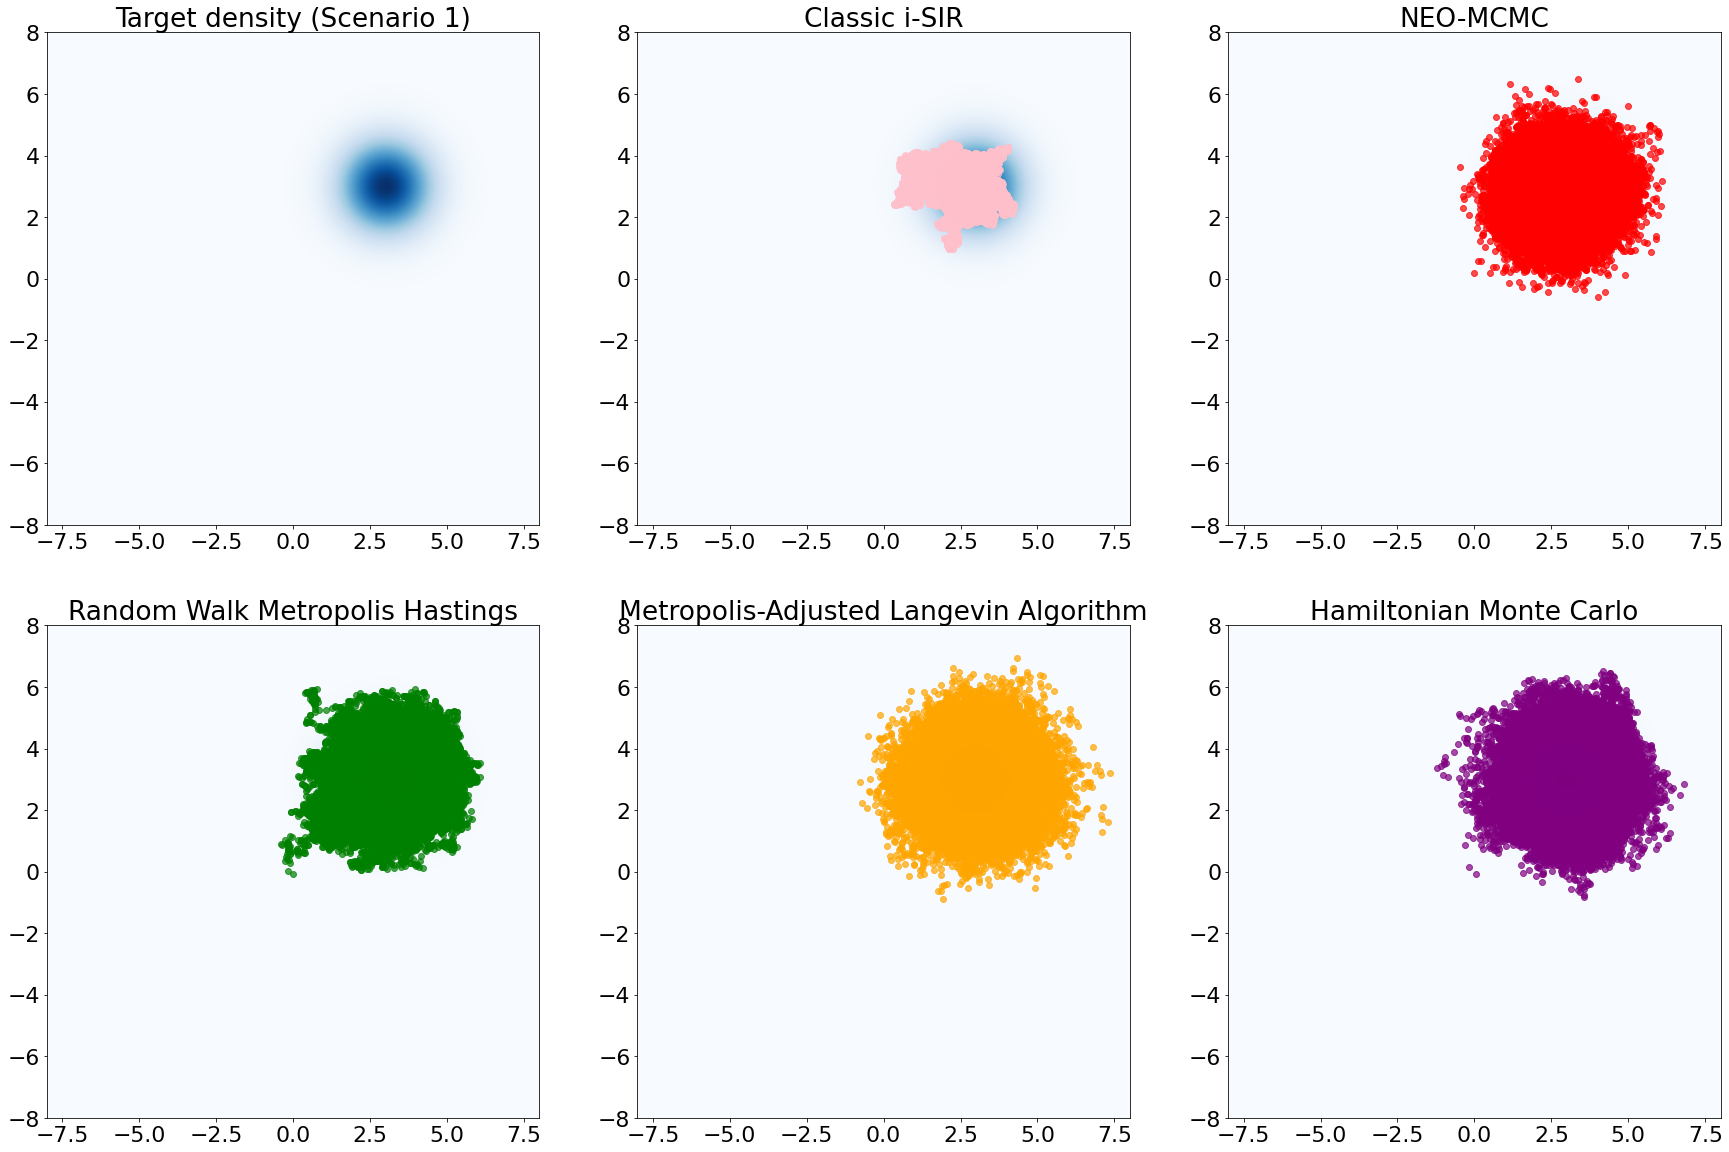

In [ ]:
# Plot everything
key = jax.random.PRNGKey(42)
q_classic_is, q_neo_is, q_mh, q_mala, q_hmc = benchmark_samplers(simple_2d_is, simple_2d_neo, simple_2d_transformation, simple_2d_distributions, sampling_parameters, simple2d_loglikelihood_is, key)
plot_samples(simple_2d_distributions['target'], q_classic_is, q_neo_is, q_mh, q_mala, q_hmc, 8, scenario_num=1)

**Interpretation**

As it was a simple task, we can see that all algorithms perfoms well at sampling from $\pi$.

### Higly multi-modal 2D gaussian

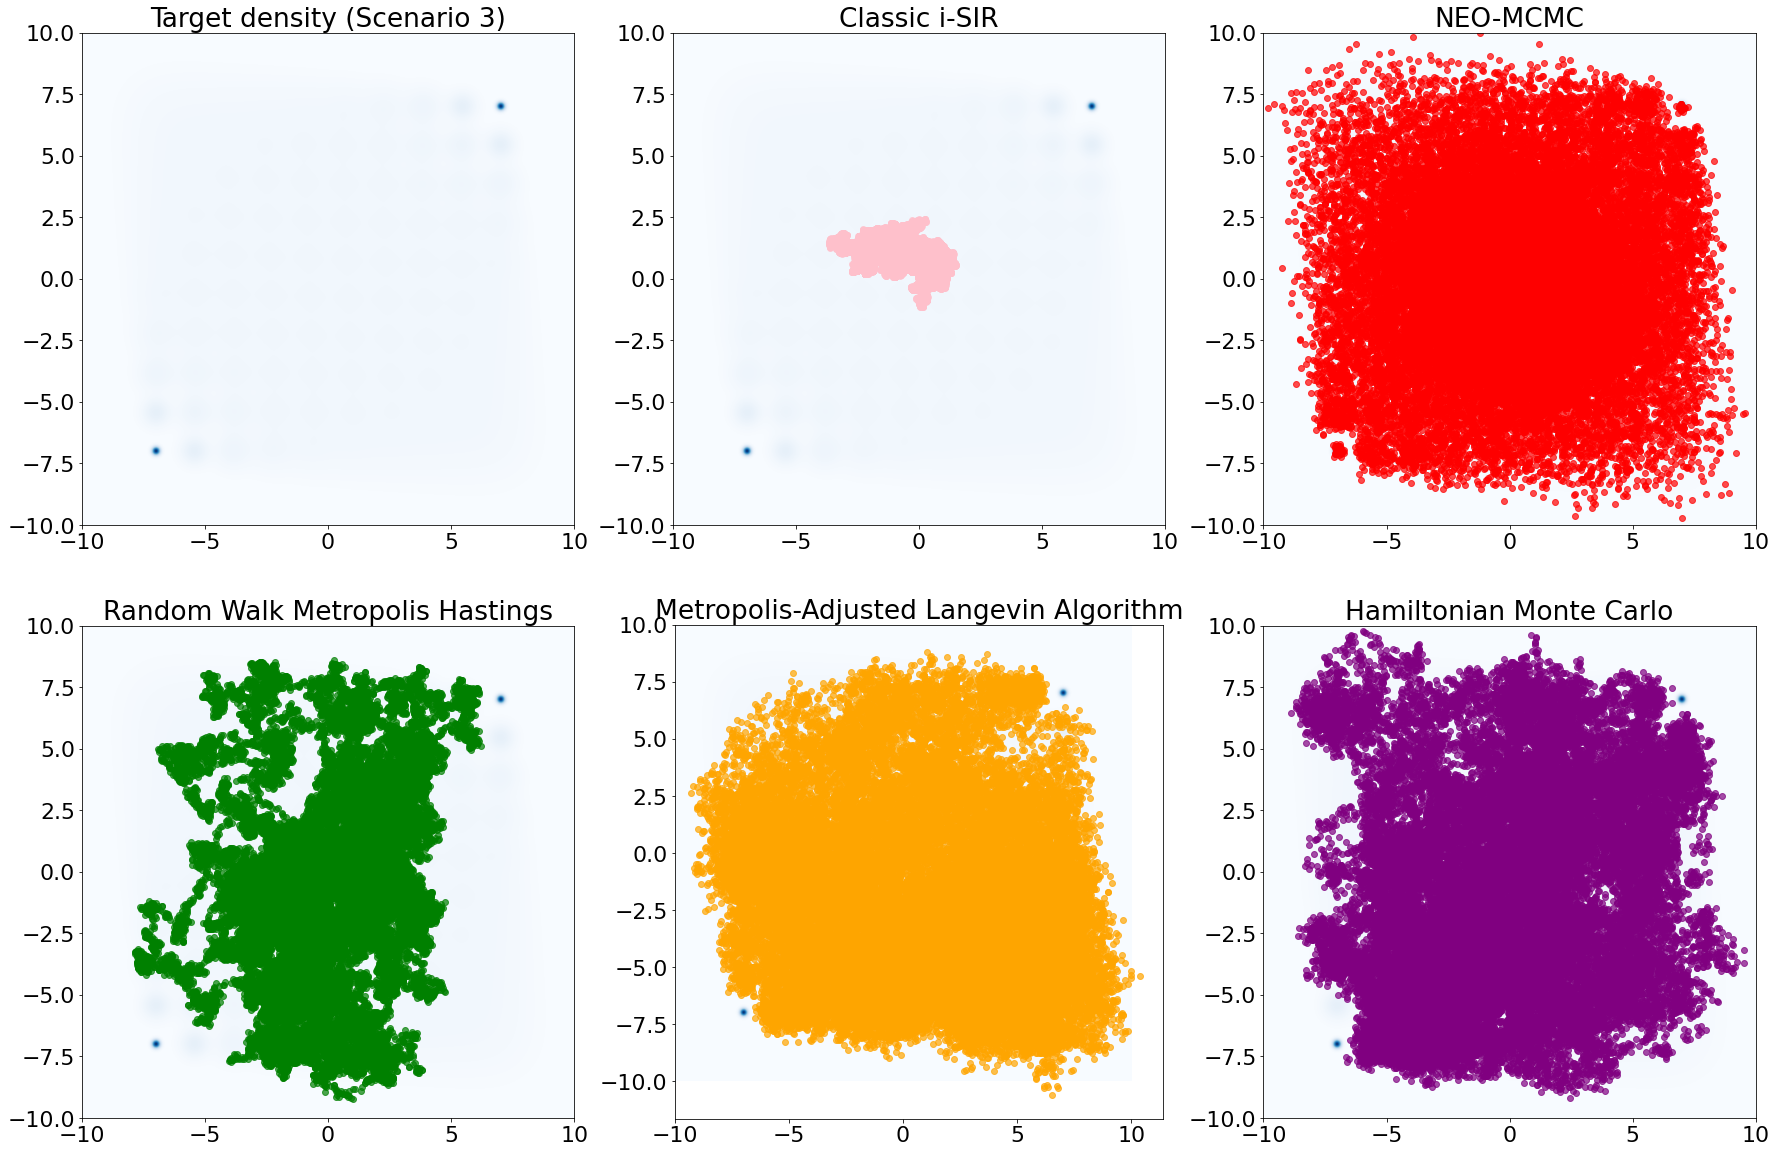

In [ ]:
# Plot everything
key = jax.random.PRNGKey(42)
q_classic_is, q_neo_is, q_mh, q_mala, q_hmc = benchmark_samplers(multi_modal_is, multi_modal_neo, multi_modal_transformation, multi_modal_distributions, sampling_parameters, multi_modal_loglikelihood_is, key)
plot_samples(multi_modal_distributions['target'], q_classic_is, q_neo_is, q_mh, q_mala, q_hmc, 10, scenario_num=3)

**Interpretation**

This example is very interessting. The top left plot shows how flat and widespread the target distribution is, which makes sampling from it very challenging.

The first looser of this competition is classic i-SIR which clearly lacks exploration abilities. 

Moreover, we can see that NEO-MCMC is the only one to explore enough to sample from the high-mass modes. This highlights a big difficulty when designing scenarios: using a good prior. Indeed, the prior used here is a standard gaussian in the middle of the square (a very low mass area). This makes exploring modes far away very difficult (as showed by RW-MH). 

Overall, with the exact same number of samples, NEO-MCMC is the one which explores the largest part of the target distribution. MALA and HMC are good as well but go short on the borders of the square.

# References

[França et al., 2020] Guilherme França et al. “Conformal symplectic and relativistic optimization.” In: Journal of Statistical Mechanics: Theory and Experiment 2020.12 (Dec. 2020), p. 124008. issn: 1742-5468. doi: 10.1088/1742- 5468/abcaee. url: http://dx.doi.org/10.1088/1742-5468/abcaee.

[Neal, 2001] Radford M. Neal. “Annealed importance sampling.” In: Statistics and Computing 11.2 (Apr. 2001), pp. 125–139. issn: 1573-1375. doi: 10.1023 A:1008923215028. url: https://doi.org/10.1023/A:1008923215028

[Owen, 2018] Art Owen. Importance sampling. 2018. url: https://artowen.su.domains/mc Ch-var-is.pdf

[Owen and Zhou, 2000] Art B. Owen and Yi Zhou. “Safe and Effective Importance Sampling.” In: Journal of the American Statistical Association 95 (2000), pp. 135–143

[Rotskoff and Vanden-Eijnden, 2019] Grant M. Rotskoff and Eric Vanden-Eijnden. “Dynamical Computation of the Density of States and Bayes Factors Using Nonequilibrium Importance Sampling.” In: Physical Review Letters 122.15 (Apr. 2019). issn: 1079-7114. doi: 10.1103/physrevlett.122.150602. url:http://dx.doi.org/10.1103/PhysRevLett.122.15060

[Rubin and B, 1987] Rubin and D. B. “Comment: A noniterative sampling/importance resampling alternative
to the data augmentation algorithm for creating a few imputations when fractions of missing information are modest: The SIR algorithm.” In: Journal of the American Statistical Association 82.398 (1987), pp. 542–543

[SKare et al., 2003] Øivin SKare et al. “Improved sampling-importance resampling and reduced bias im-portance sampling.” In: Scandinavian Journal of Statistics 30.4 (2003), pp. 719–737. url:http://www.jstor.org/stable/4616798

[Thin et al., 2021] Achille Thin et al. NEO: Non Equilibrium Sampling on the Orbit of a Deterministic Transform.2021. arXiv: 2103.10943 [stat.CO]